# Modelo de Clustering para Identificación de Perfiles de Jugadores

*Comprensión del Negocio* 

1.1 Contexto del Negocio
En el fútbol moderno, identificar patrones naturales en el estilo de juego de los jugadores es crucial para:

 - Identificar roles tácticos más allá de las posiciones tradicionales
 - Encontrar jugadores similares para reemplazos o fichajes
 - Desarrollar estrategias personalizadas según los perfiles disponibles
 - Optimizar la composición del equipo y las tácticas

1.2 Objetivos del Proyecto
Desarrollar un modelo de clustering que:

 - Identifique grupos naturales de jugadores basados en sus características de juego
 - Ofrezca una interpretación clara de los perfiles identificados
 - Permita clasificar nuevos jugadores en los perfiles existentes
 - Proporcione herramientas para la visualización y comparación de perfiles

1.3 Criterios de Éxito

 - Identificar clusters con interpretación futbolística clara
 - Lograr métricas de validación interna satisfactorias (coeficiente de silueta > 0.5)
 - Encontrar clusters que no se correspondan únicamente con las posiciones tradicionales
 - Generar insights accionables para scouts, entrenadores y directores deportivos

In [1]:
# Carga de eventos

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Cargar el dataset
data = pd.read_parquet('data/eventos_datos_acumulados.parquet')
print(f"Dimensiones del DataFrame: {data.shape}")

Dimensiones del DataFrame: (14186, 191)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14186 entries, 0 to 14185
Columns: 191 entries, match_id to KPI_rendimiento
dtypes: float64(91), int64(90), object(10)
memory usage: 20.7+ MB


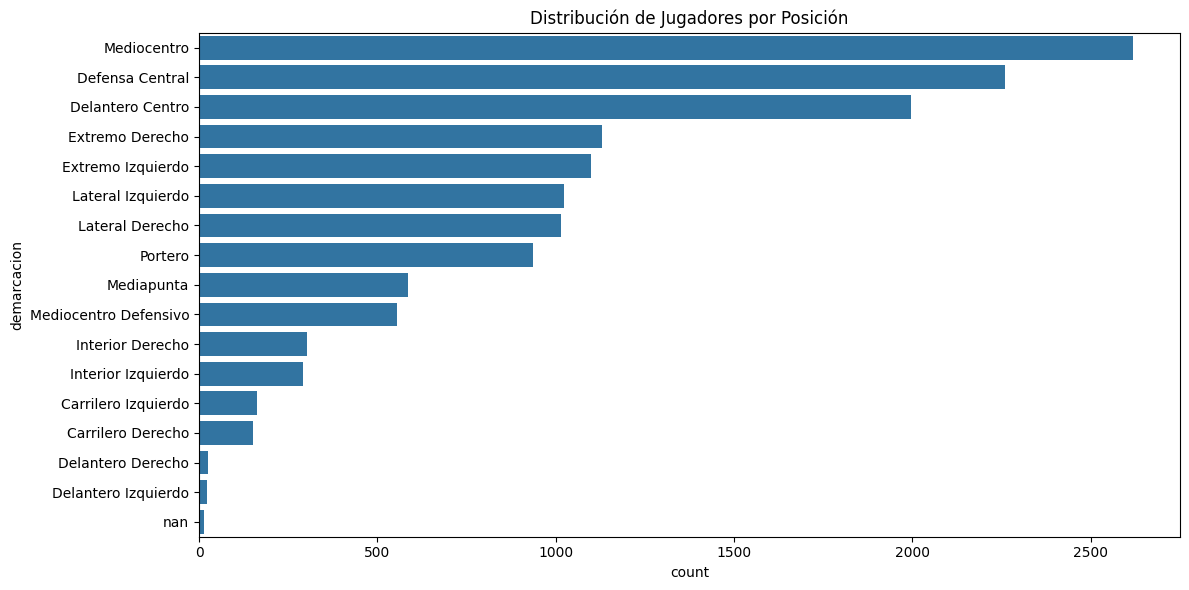

Columnas con valores nulos:
Total de columnas con nulos: 86
goles                          29
tiros_totales                  29
tiros_a_porteria               29
tiros_fuera                    29
tiros_bloqueados               29
                               ..
KPI_eficacia_defensiva         29
KPI_juego_aereo                29
KPI_capacidad_recuperacion     29
KPI_posicionamiento_tactico    29
KPI_rendimiento                29
Length: 86, dtype: int64


In [2]:
# Revisar las primeras filas
data.head()

# Información del dataset
data.info()

# Estadísticas descriptivas básicas
data.describe()

# Distribución de posiciones
plt.figure(figsize=(12, 6))
sns.countplot(y='demarcacion', data=data, order=data['demarcacion'].value_counts().index)
plt.title('Distribución de Jugadores por Posición')
plt.tight_layout()
plt.show()

# Verificar valores nulos
print("Columnas con valores nulos:")
null_columns = data.columns[data.isnull().any()].tolist()
print(f"Total de columnas con nulos: {len(null_columns)}")
if len(null_columns) > 0:
    print(data[null_columns].isnull().sum())

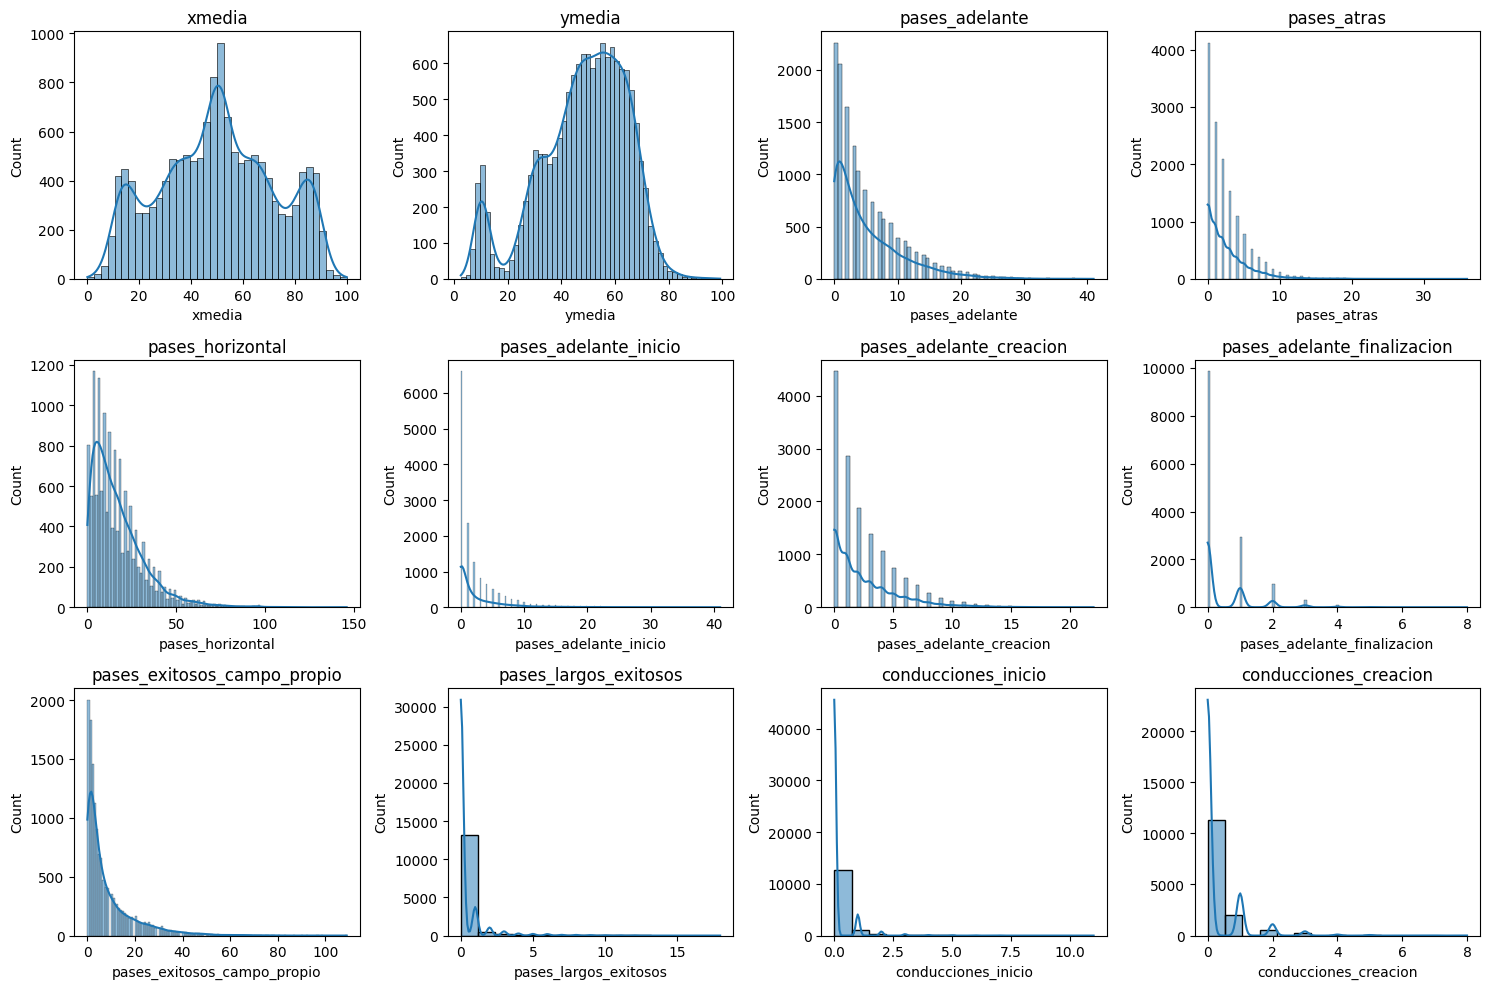

In [3]:
# Variables potencialmente relevantes para clustering
vars_clustering = [
    # Distribución espacial
    'xmedia', 'ymedia',
    
    # Métricas de pases
    'pases_adelante', 'pases_atras', 'pases_horizontal',
    'pases_adelante_inicio', 'pases_adelante_creacion', 'pases_adelante_finalizacion',
    'pases_exitosos_campo_propio', 'pases_largos_exitosos',
    
    # Conducción y regates
    'conducciones_inicio', 'conducciones_creacion', 'conducciones_finalizacion',
    'conducciones_carril_izquierdo', 'conducciones_carril_central', 'conducciones_carril_derecho',
    'regates_zona_inicio', 'regates_zona_creacion', 'regates_zona_finalizacion',
    
    # Acciones defensivas
    'intercepciones_zona_baja', 'intercepciones_zona_media', 'intercepciones_zona_alta',
    'recuperaciones_zona_baja', 'recuperaciones_zona_media', 'recuperaciones_zona_alta',
    'entradas_ganadas_zona_baja', 'entradas_ganadas_zona_media', 'entradas_ganadas_zona_alta',
    
    # Duelos
    'duelos_aereos_ganados_zona_baja', 'duelos_aereos_ganados_zona_media', 'duelos_aereos_ganados_zona_alta',
    'duelos_suelo_ganados_zona_baja', 'duelos_suelo_ganados_zona_media', 'duelos_suelo_ganados_zona_alta',
    
    # Finalización
    'disparos_a_puerta', 'disparos_fuera', 'xg'
]

# Análisis de distribución de algunas variables clave
plt.figure(figsize=(15, 10))
for i, var in enumerate(vars_clustering[:12]):  # Primeras 12 variables para visualización
    plt.subplot(3, 4, i+1)
    sns.histplot(data[var].dropna(), kde=True)
    plt.title(var)
    plt.tight_layout()
plt.show()

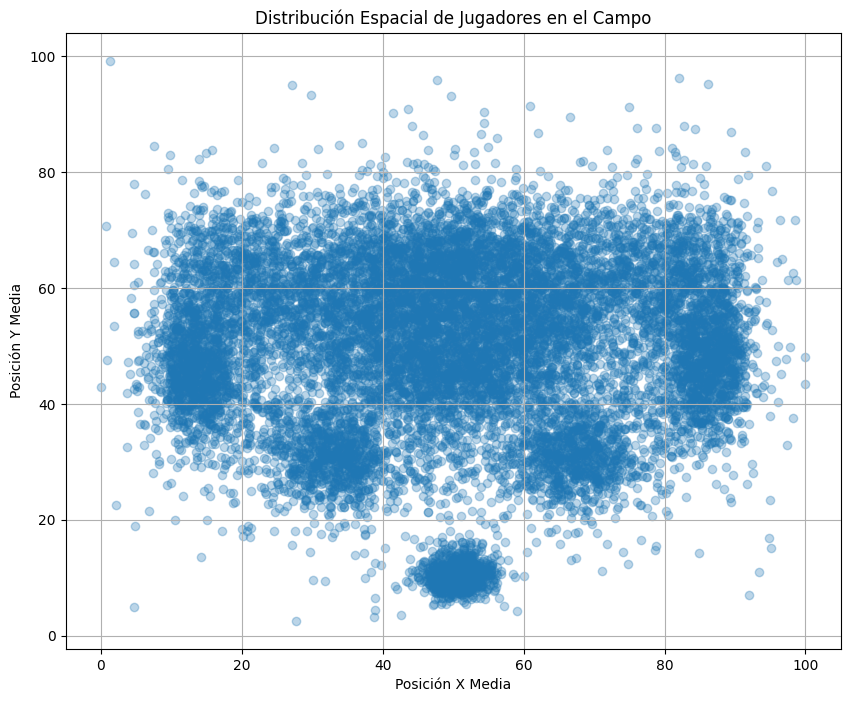

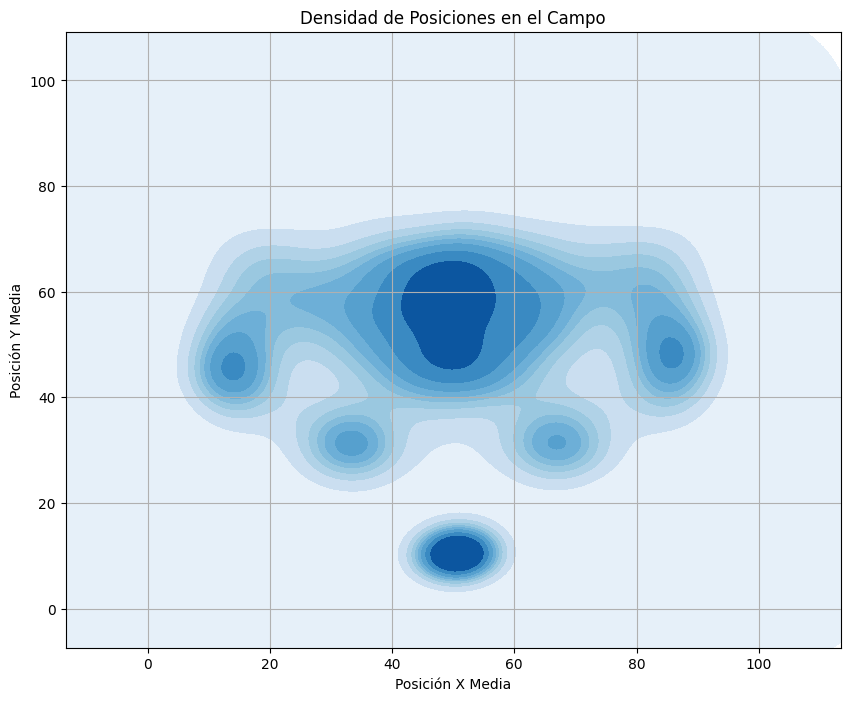

In [4]:
# Gráfico de dispersión para posición media en el campo
plt.figure(figsize=(10, 8))
plt.scatter(data['xmedia'], data['ymedia'], alpha=0.3)
plt.title('Distribución Espacial de Jugadores en el Campo')
plt.xlabel('Posición X Media')
plt.ylabel('Posición Y Media')
plt.grid(True)
plt.show()

# Gráfico de densidad 2D para posición media en el campo
plt.figure(figsize=(10, 8))
sns.kdeplot(x=data['xmedia'], y=data['ymedia'], cmap="Blues", fill=True, thresh=0)
plt.title('Densidad de Posiciones en el Campo')
plt.xlabel('Posición X Media')
plt.ylabel('Posición Y Media')
plt.grid(True)
plt.show()


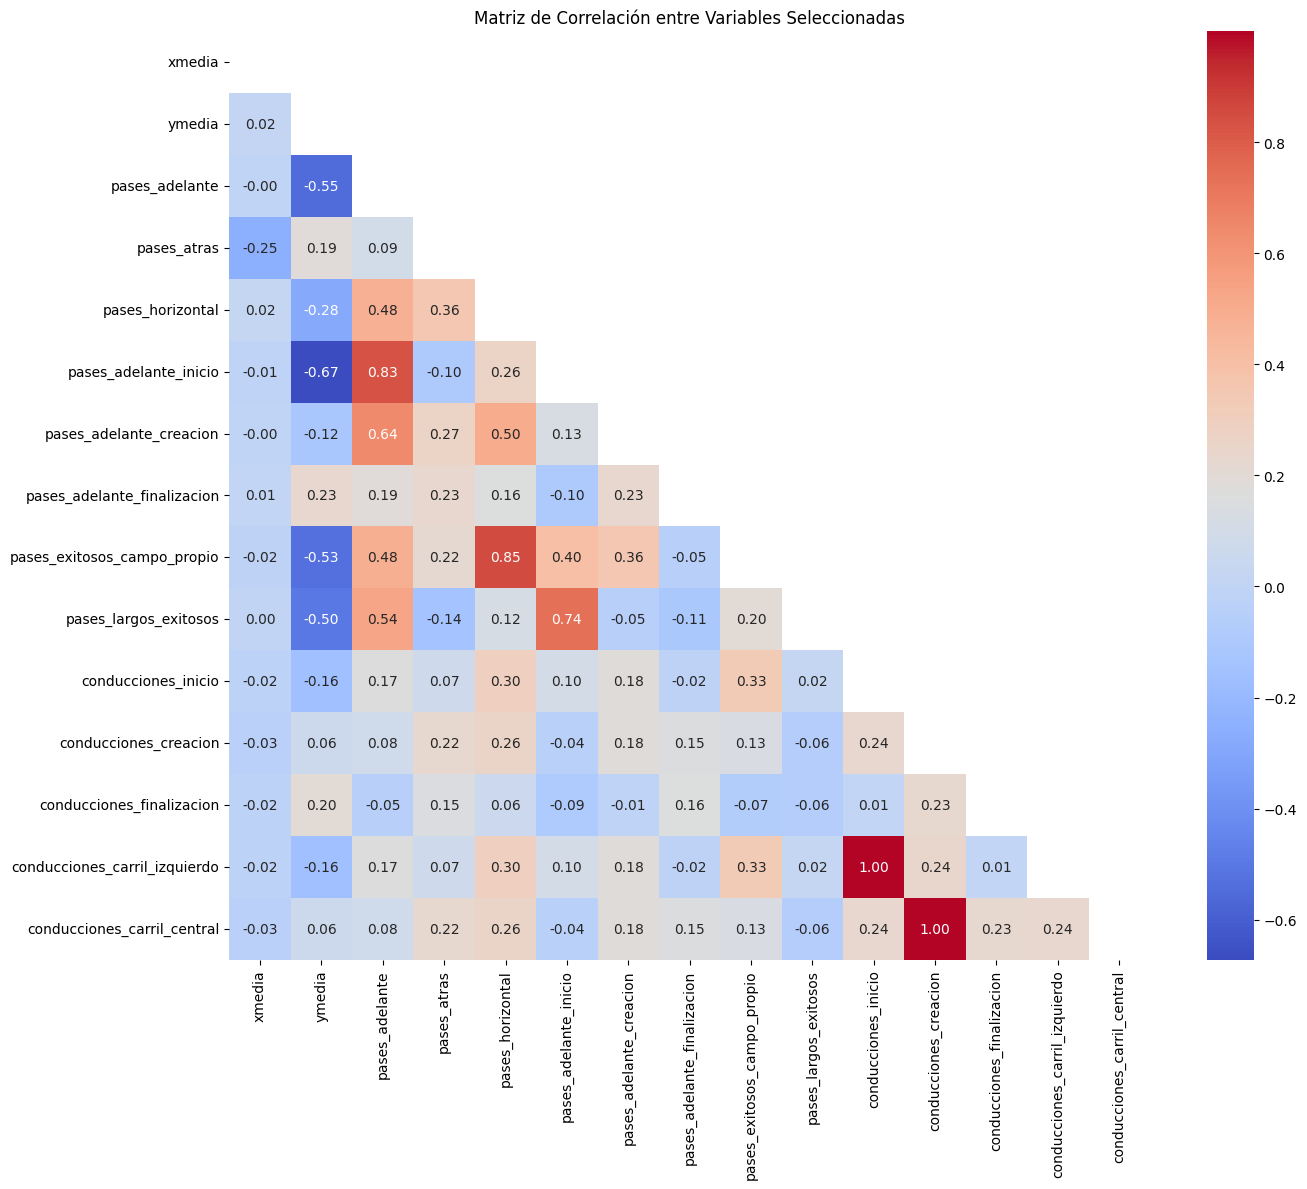

In [5]:
# Seleccionar un subconjunto de variables para mejor visualización
vars_selected = vars_clustering[:15]  # Primeras 15 variables

# Matriz de correlación
plt.figure(figsize=(14, 12))
correlation_matrix = data[vars_selected].corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
plt.title('Matriz de Correlación entre Variables Seleccionadas')
plt.tight_layout()
plt.show()

In [6]:
# Filtrar jugadores con minutos jugados significativos (>= 45 minutos)
data_prep = data.copy()
data_prep = data_prep[data_prep['minutos_jugados'] >= 45]
print(f"Registros después del filtrado: {data_prep.shape[0]}")

Registros después del filtrado: 10376


In [7]:
# Normalizar métricas por 90 minutos para comparabilidad
for var in vars_clustering:
    if var not in ['xmedia', 'ymedia']:  # No normalizar coordenadas espaciales
        data_prep[f'{var}_por90'] = data_prep[var] * 90 / data_prep['minutos_jugados']

# Actualizar la lista de variables con las normalizadas
vars_clustering_norm = ['xmedia', 'ymedia'] + [f'{var}_por90' for var in vars_clustering if var not in ['xmedia', 'ymedia']]

In [8]:
# Rellenar valores nulos con 0 para métricas de juego
for col in vars_clustering_norm:
    if data_prep[col].isnull().sum() > 0:
        data_prep[col] = data_prep[col].fillna(0)

# Verificar que no queden nulos
nulos = data_prep[vars_clustering_norm].isnull().sum().sum()
print(f"Valores nulos restantes: {nulos}")

Valores nulos restantes: 0


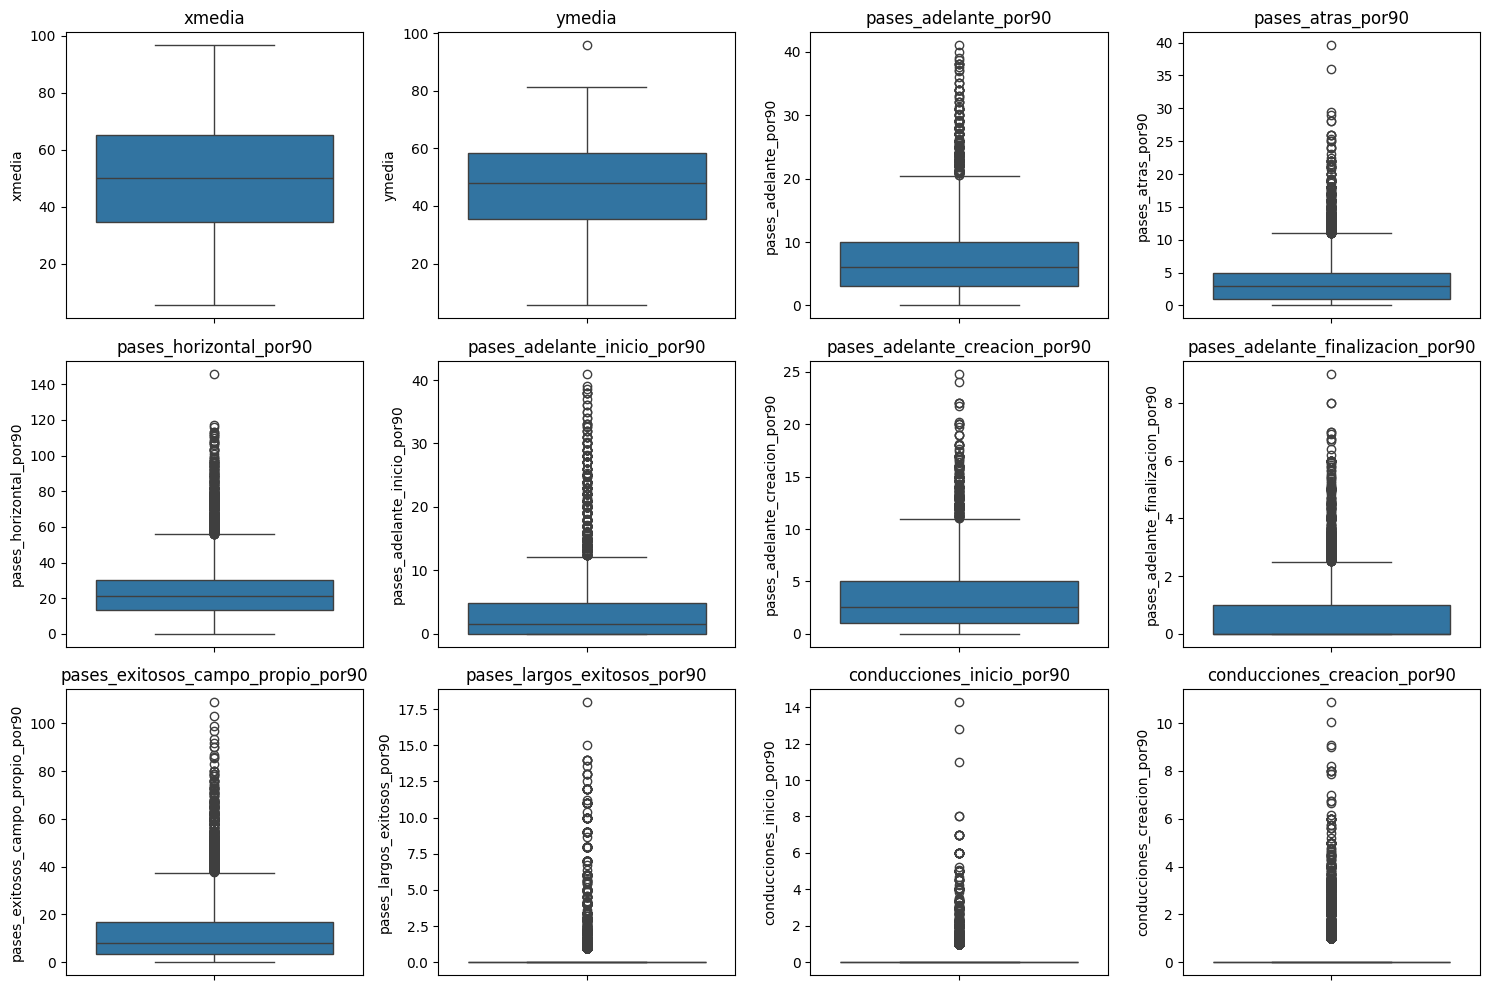

In [9]:
# Identificar outliers usando el método IQR
def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    return outliers

# Visualizar outliers para algunas variables clave
plt.figure(figsize=(15, 10))
for i, var in enumerate(vars_clustering_norm[:12]):  # Primeras 12 variables
    plt.subplot(3, 4, i+1)
    sns.boxplot(y=data_prep[var])
    plt.title(var)
    plt.tight_layout()
plt.show()

# Aplicar transformación logarítmica a variables muy sesgadas
for var in vars_clustering_norm:
    # Solo aplicar a variables numéricas positivas con asimetría
    if data_prep[var].skew() > 1 and (data_prep[var] > 0).all():
        data_prep[f'{var}_log'] = np.log1p(data_prep[var])
        vars_clustering_norm[vars_clustering_norm.index(var)] = f'{var}_log'

# Alternativamente, puedes optar por eliminar outliers
# data_prep = data_prep[data_prep['disparos_a_puerta_por90'] < upper_bound]

In [10]:
# Seleccionar solo las variables para clustering
X = data_prep[vars_clustering_norm].copy()

# Estandarizar variables (media=0, desviación=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir de nuevo a DataFrame para mejor manipulación
X_scaled_df = pd.DataFrame(X_scaled, columns=vars_clustering_norm, index=X.index)

In [11]:
# Seleccionar solo las variables para clustering
X = data_prep[vars_clustering_norm].copy()

# Estandarizar variables (media=0, desviación=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir de nuevo a DataFrame para mejor manipulación
X_scaled_df = pd.DataFrame(X_scaled, columns=vars_clustering_norm, index=X.index)

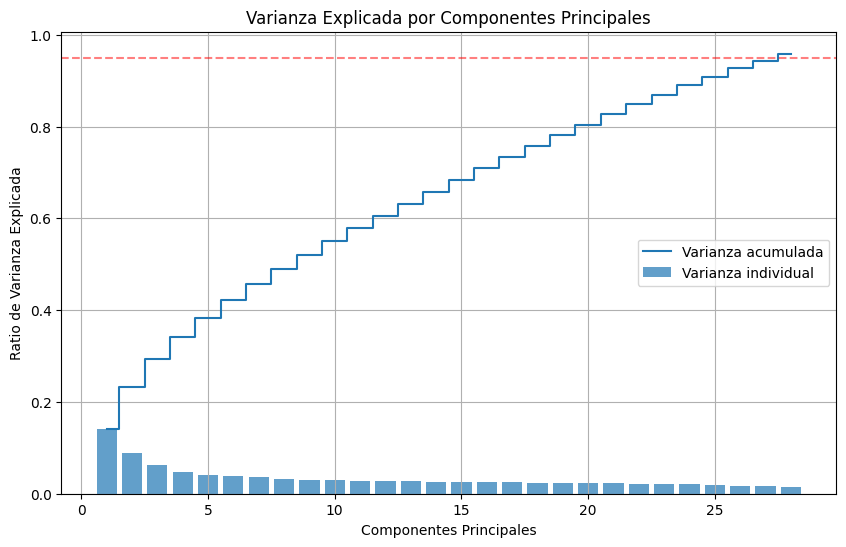

Número de componentes seleccionados: 28
Varianza explicada: 95.86%


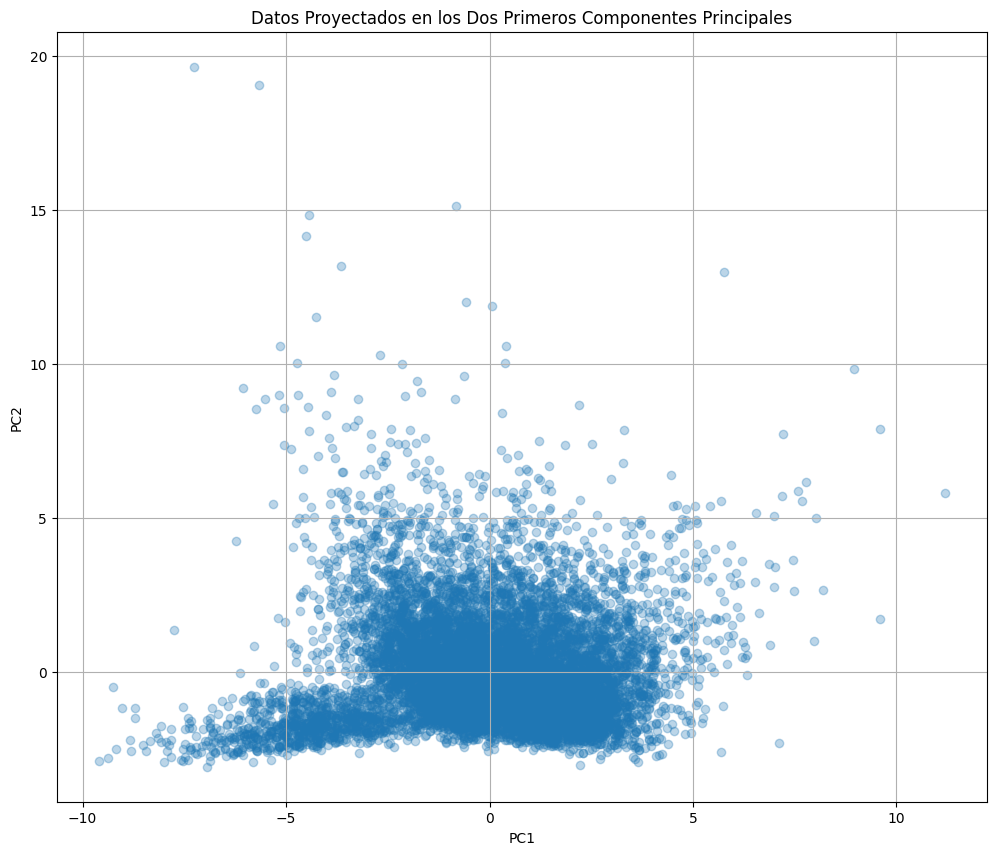

In [12]:
# Aplicar PCA para visualización y reducción de dimensionalidad
pca = PCA(n_components=0.95)  # Mantener el 95% de la varianza
X_pca = pca.fit_transform(X_scaled)

# Analizar componentes principales
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Visualizar varianza explicada
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center',
        label='Varianza individual')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid',
         label='Varianza acumulada')
plt.axhline(y=0.95, linestyle='--', color='r', alpha=0.5)
plt.title('Varianza Explicada por Componentes Principales')
plt.xlabel('Componentes Principales')
plt.ylabel('Ratio de Varianza Explicada')
plt.legend(loc='best')
plt.grid(True)
plt.show()

print(f"Número de componentes seleccionados: {X_pca.shape[1]}")
print(f"Varianza explicada: {cumulative_variance[-1]:.2%}")

# Visualizar datos en primeros 2 componentes principales
plt.figure(figsize=(12, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.3)
plt.title('Datos Proyectados en los Dos Primeros Componentes Principales')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

# Extraer 2 primeros componentes para visualización posterior
X_pca_2d = X_pca[:, :2]

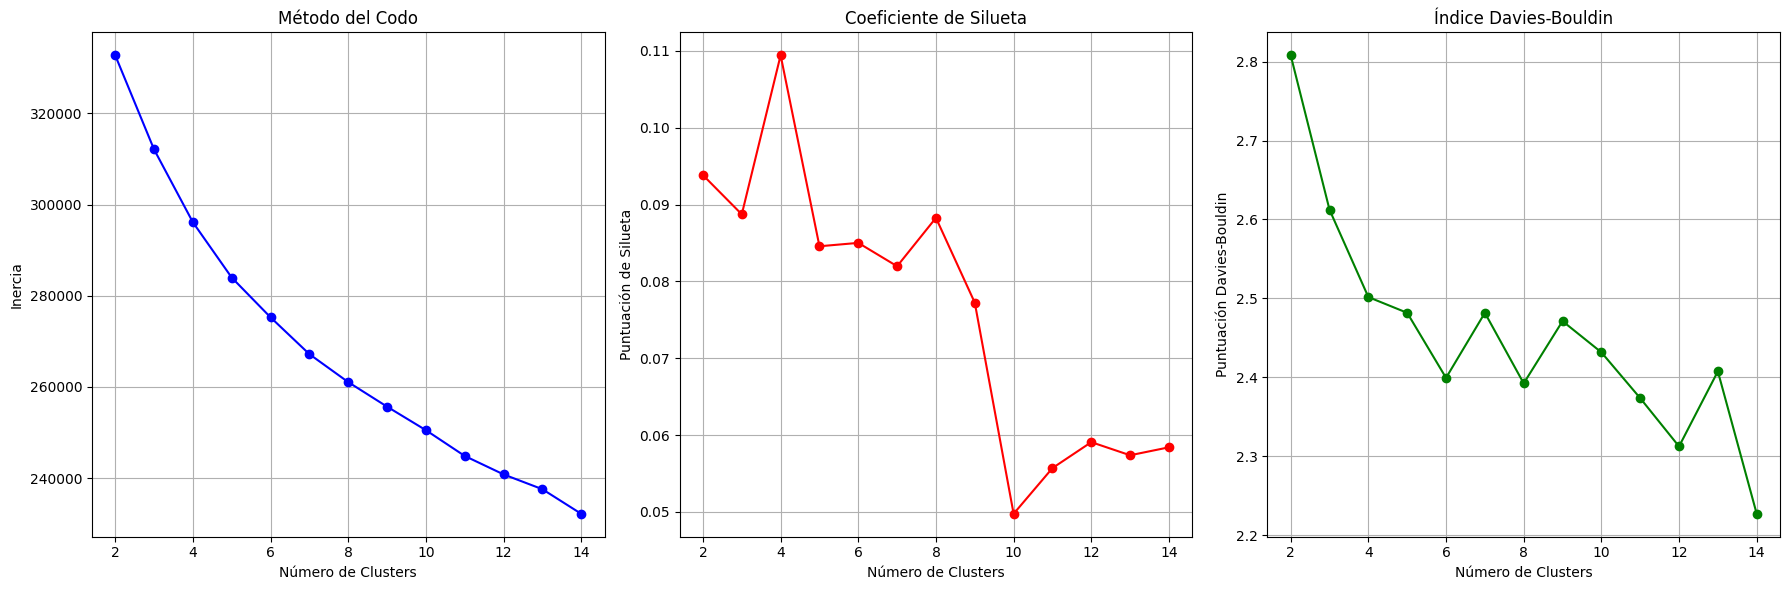

Número óptimo de clusters según coeficiente de silueta: 4


In [13]:
# Método del codo para determinar el número óptimo de clusters
inertias = []
silhouette_scores = []
davies_bouldin_scores = []
k_range = range(2, 15)

for k in k_range:
    # Entrenar KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    
    # Calcular inercia
    inertias.append(kmeans.inertia_)
    
    # Calcular coeficiente de silueta
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(X_pca, labels))
    
    # Calcular índice Davies-Bouldin
    davies_bouldin_scores.append(davies_bouldin_score(X_pca, labels))

# Visualizar resultados
plt.figure(figsize=(18, 6))

# Método del codo
plt.subplot(1, 3, 1)
plt.plot(k_range, inertias, 'bo-')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)

# Coeficiente de silueta
plt.subplot(1, 3, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.title('Coeficiente de Silueta')
plt.xlabel('Número de Clusters')
plt.ylabel('Puntuación de Silueta')
plt.grid(True)

# Índice Davies-Bouldin
plt.subplot(1, 3, 3)
plt.plot(k_range, davies_bouldin_scores, 'go-')
plt.title('Índice Davies-Bouldin')
plt.xlabel('Número de Clusters')
plt.ylabel('Puntuación Davies-Bouldin')
plt.grid(True)

plt.tight_layout()
plt.show()

# Determinar número óptimo de clusters basado en las métricas
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Número óptimo de clusters según coeficiente de silueta: {optimal_k}")

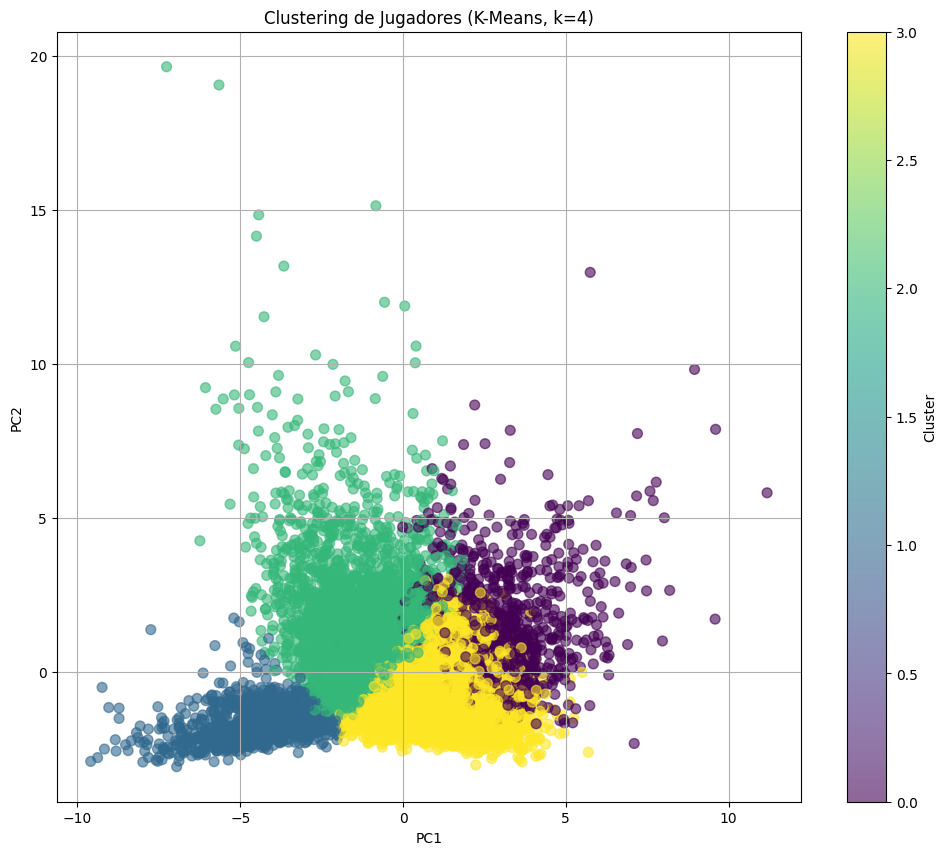

In [14]:
# Aplicar K-Means con el número óptimo de clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

# Añadir etiquetas de cluster al dataframe original
data_prep['cluster'] = cluster_labels

# Visualizar resultados en 2D con los dos primeros componentes principales
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter, label='Cluster')
plt.title(f'Clustering de Jugadores (K-Means, k={optimal_k})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

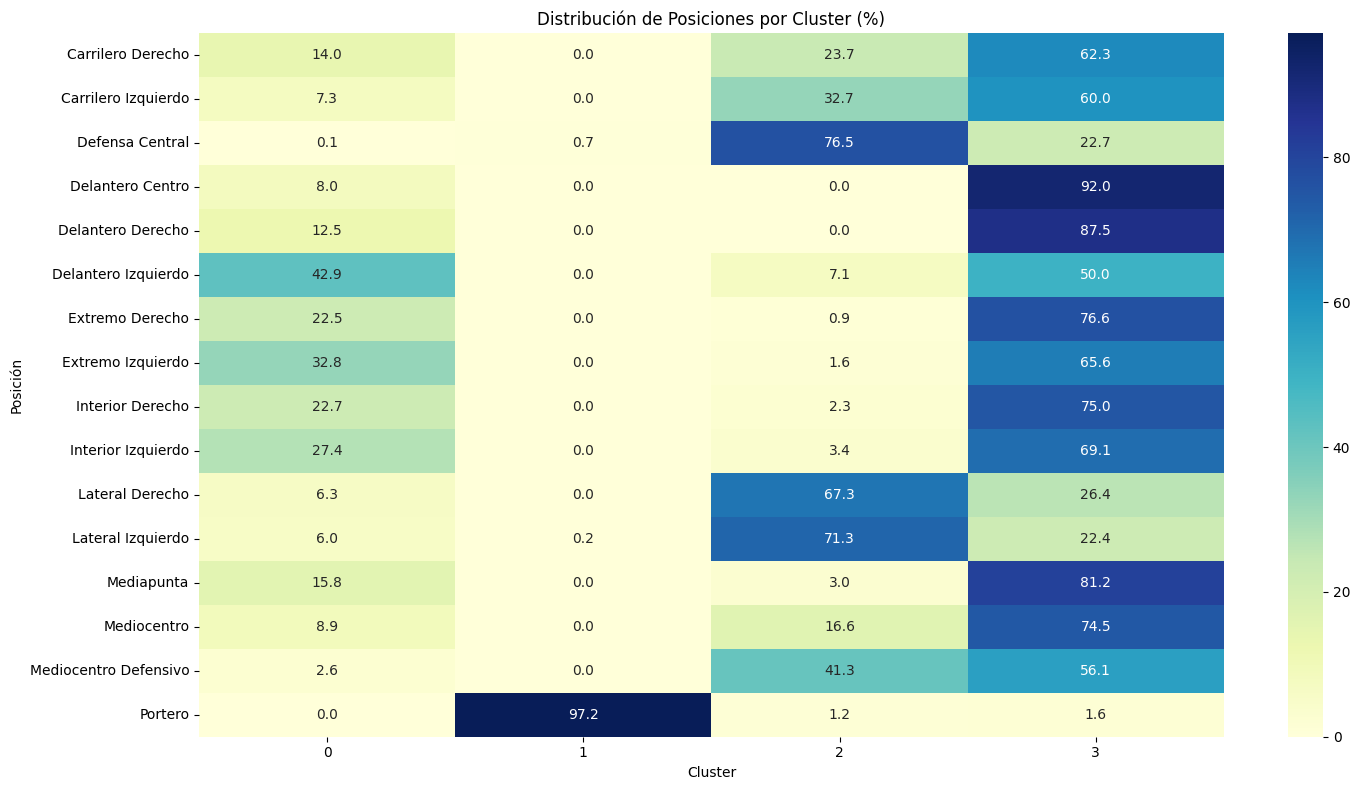

Distribución de posiciones por cluster:
cluster                  0    1     2     3
demarcacion                                
Carrilero Derecho       16    0    27    71
Carrilero Izquierdo      8    0    36    66
Defensa Central          2   14  1516   450
Delantero Centro        97    0     0  1114
Delantero Derecho        2    0     0    14
Delantero Izquierdo      6    0     1     7
Extremo Derecho        154    0     6   524
Extremo Izquierdo      226    0    11   452
Interior Derecho        39    0     4   129
Interior Izquierdo      48    0     6   121
Lateral Derecho         52    0   554   217
Lateral Izquierdo       49    2   582   183
Mediapunta              58    0    11   298
Mediocentro            165    0   307  1382
Mediocentro Defensivo   11    0   175   238
Portero                  0  899    11    15

Distribución porcentual:
cluster                        0          1          2          3
demarcacion                                                      
Carrilero 

In [15]:
# Añadir componentes principales al dataframe para análisis
data_prep['PC1'] = X_pca[:, 0]
data_prep['PC2'] = X_pca[:, 1]

# Análisis de distribución de posiciones por cluster
plt.figure(figsize=(15, 8))
crosstab = pd.crosstab(data_prep['demarcacion'], data_prep['cluster'])
crosstab_percentage = crosstab.div(crosstab.sum(axis=1), axis=0) * 100

# Heatmap de distribución de posiciones por cluster
sns.heatmap(crosstab_percentage, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Distribución de Posiciones por Cluster (%)')
plt.ylabel('Posición')
plt.xlabel('Cluster')
plt.tight_layout()
plt.show()

# Tabla de distribución
print("Distribución de posiciones por cluster:")
print(crosstab)
print("\nDistribución porcentual:")
print(crosstab_percentage)

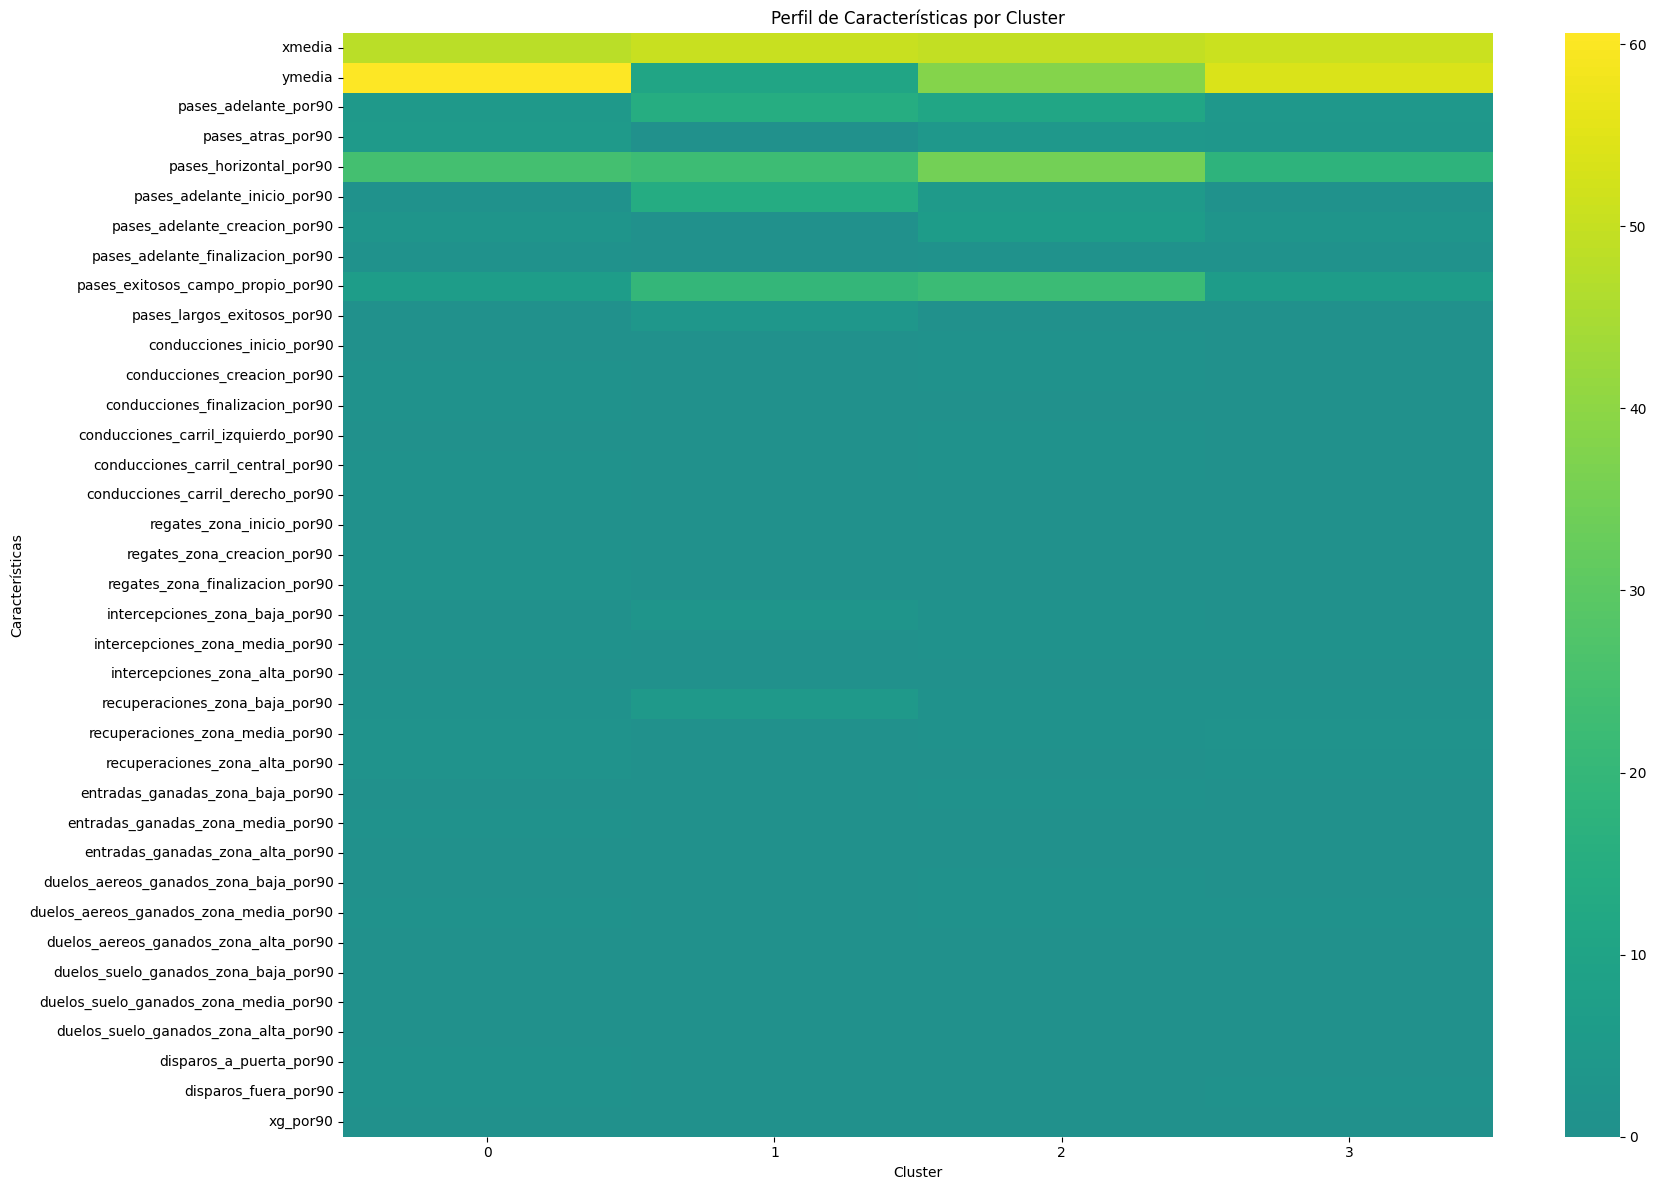

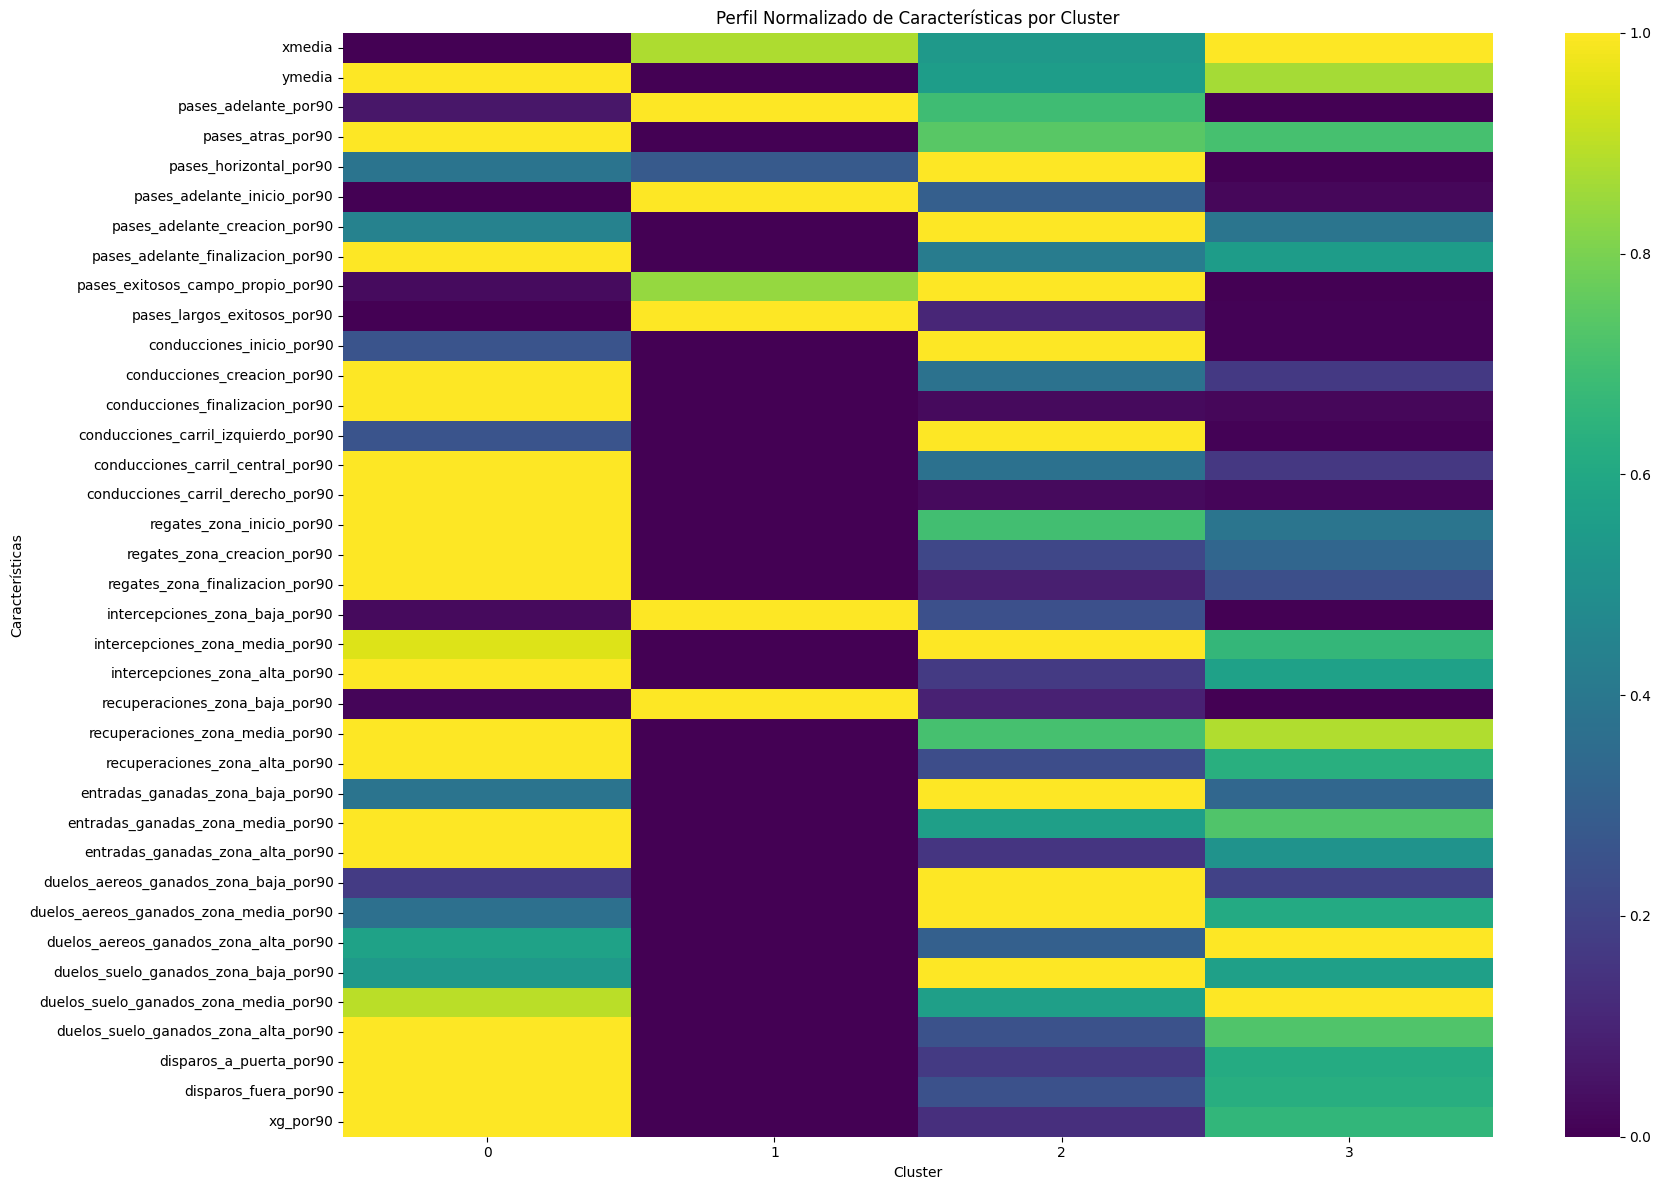

In [16]:
# Calcular el perfil de cada cluster (medias de características por cluster)
cluster_profiles = data_prep.groupby('cluster')[vars_clustering_norm].mean()

# Visualizar perfiles en un heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(cluster_profiles.T, cmap='viridis', center=0, annot=False)
plt.title('Perfil de Características por Cluster')
plt.ylabel('Características')
plt.xlabel('Cluster')
plt.tight_layout()
plt.show()

# Normalizar perfiles para mejor visualización comparativa
profiles_normalized = (cluster_profiles - cluster_profiles.min()) / (cluster_profiles.max() - cluster_profiles.min())

plt.figure(figsize=(18, 12))
sns.heatmap(profiles_normalized.T, cmap='viridis', annot=False, vmin=0, vmax=1)
plt.title('Perfil Normalizado de Características por Cluster')
plt.ylabel('Características')
plt.xlabel('Cluster')
plt.tight_layout()
plt.show()

Top 10 características más discriminantes (ANOVA):
                                   F-statistic  p-value
ymedia                             6641.866263      0.0
pases_adelante_inicio_por90        5202.867180      0.0
conducciones_finalizacion_por90    4410.525285      0.0
conducciones_carril_derecho_por90  4400.846119      0.0
pases_largos_exitosos_por90        2999.476412      0.0
pases_adelante_por90               2651.825705      0.0
recuperaciones_zona_baja_por90     2331.289017      0.0
pases_exitosos_campo_propio_por90  2085.329849      0.0
pases_adelante_creacion_por90      1678.282381      0.0
pases_horizontal_por90             1175.888892      0.0


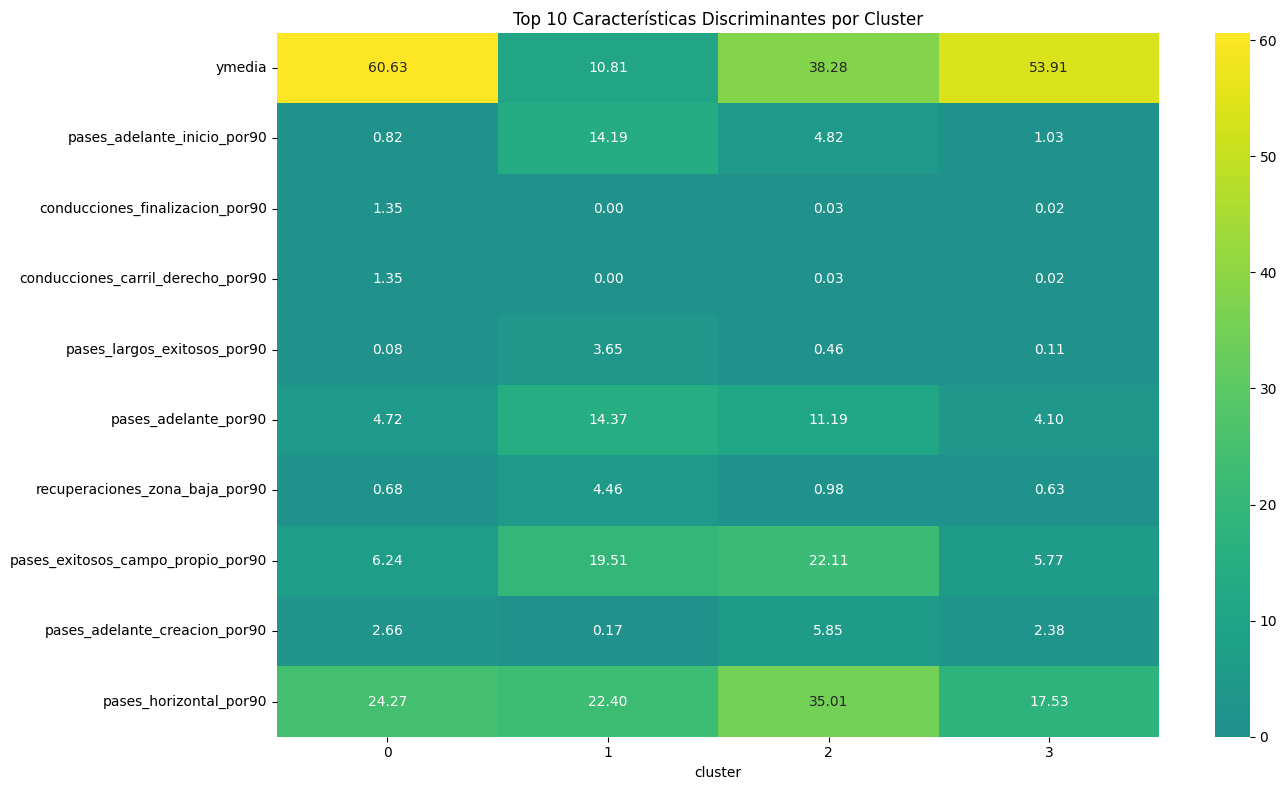

In [17]:
# Análisis de varianza para identificar las variables más discriminantes
from scipy.stats import f_oneway

# Función para calcular estadísticas F y valores p
def calc_anova(df, features, group_col='cluster'):
    f_values = {}
    p_values = {}
    
    for feature in features:
        groups = [df[df[group_col] == cluster][feature].values for cluster in df[group_col].unique()]
        f_val, p_val = f_oneway(*groups)
        f_values[feature] = f_val
        p_values[feature] = p_val
    
    return pd.DataFrame({'F-statistic': f_values, 'p-value': p_values}).sort_values('F-statistic', ascending=False)

# Calcular ANOVA para cada característica
anova_results = calc_anova(data_prep, vars_clustering_norm)
print("Top 10 características más discriminantes (ANOVA):")
print(anova_results.head(10))

# Visualizar las 10 características más discriminantes
top_features = anova_results.head(10).index.tolist()
plt.figure(figsize=(14, 8))
sns.heatmap(data_prep.groupby('cluster')[top_features].mean().T, cmap='viridis', center=0, annot=True, fmt='.2f')
plt.title('Top 10 Características Discriminantes por Cluster')
plt.tight_layout()
plt.show()

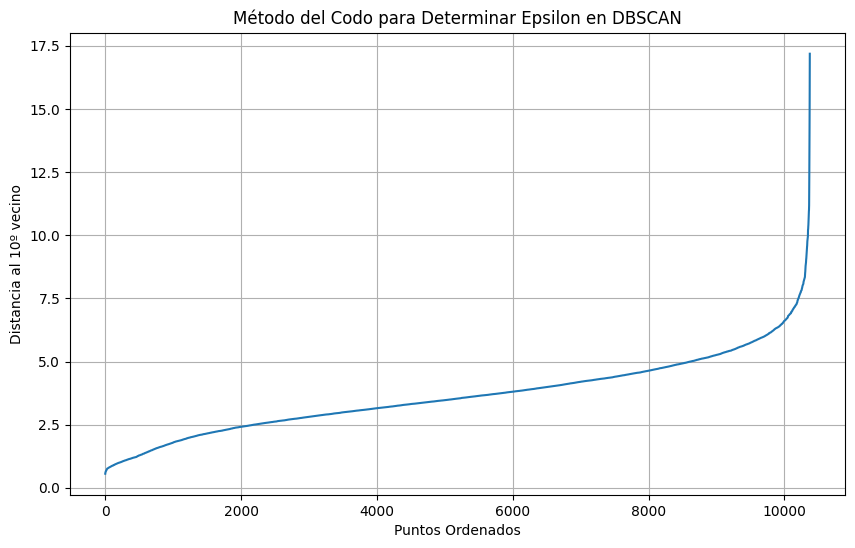

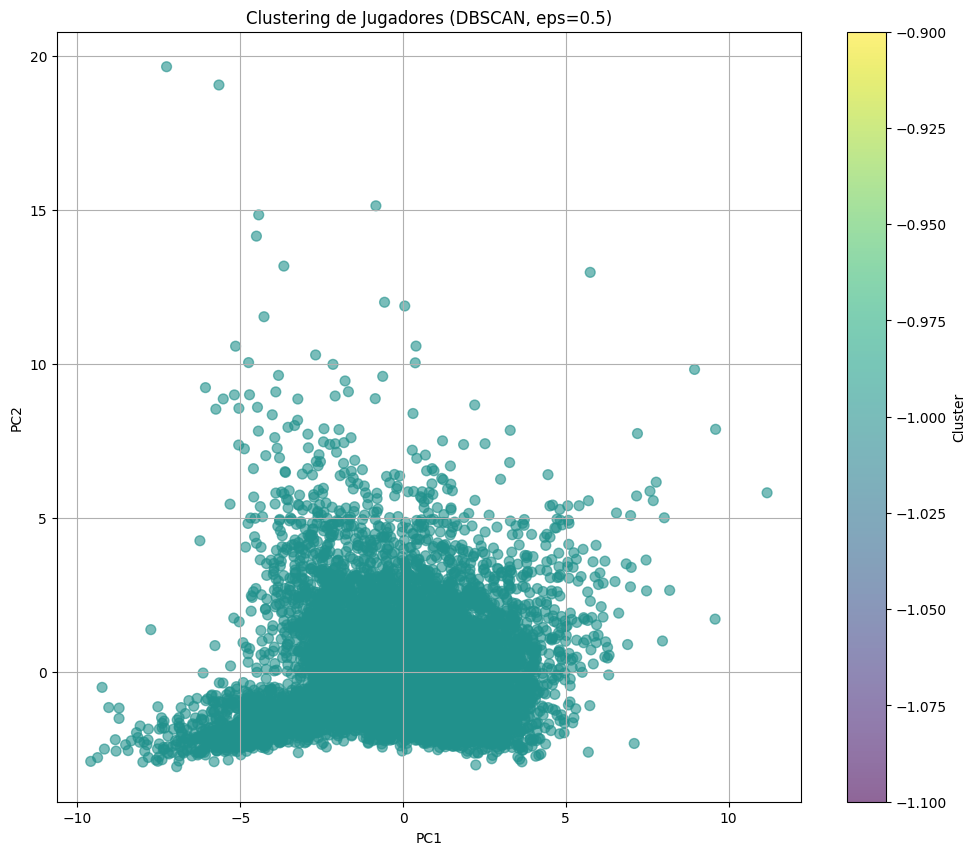

Distribución de puntos por cluster (DBSCAN):
-1    10376
Name: count, dtype: int64


In [18]:
# Determinar epsilon óptimo para DBSCAN
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)

# Ordenar distancias para el gráfico del codo
distances = np.sort(distances[:, 9])  # Distancia al vecino 10

# Visualizar para encontrar el punto de inflexión
plt.figure(figsize=(10, 6))
plt.plot(range(len(distances)), distances)
plt.title('Método del Codo para Determinar Epsilon en DBSCAN')
plt.xlabel('Puntos Ordenados')
plt.ylabel('Distancia al 10º vecino')
plt.grid(True)
plt.show()

# Seleccionar epsilon basado en el punto de inflexión
# (este valor debe ajustarse manualmente después de ver el gráfico)
epsilon = 0.5  # Valor ejemplo, ajustar según el gráfico

# Aplicar DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_pca)

# Añadir etiquetas al dataframe
data_prep['dbscan_cluster'] = dbscan_labels

# Visualizar resultados
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter, label='Cluster')
plt.title(f'Clustering de Jugadores (DBSCAN, eps={epsilon})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

# Contar puntos por cluster
cluster_counts = pd.Series(dbscan_labels).value_counts().sort_index()
print("Distribución de puntos por cluster (DBSCAN):")
print(cluster_counts)

# Nota: El cluster -1 representa outliers

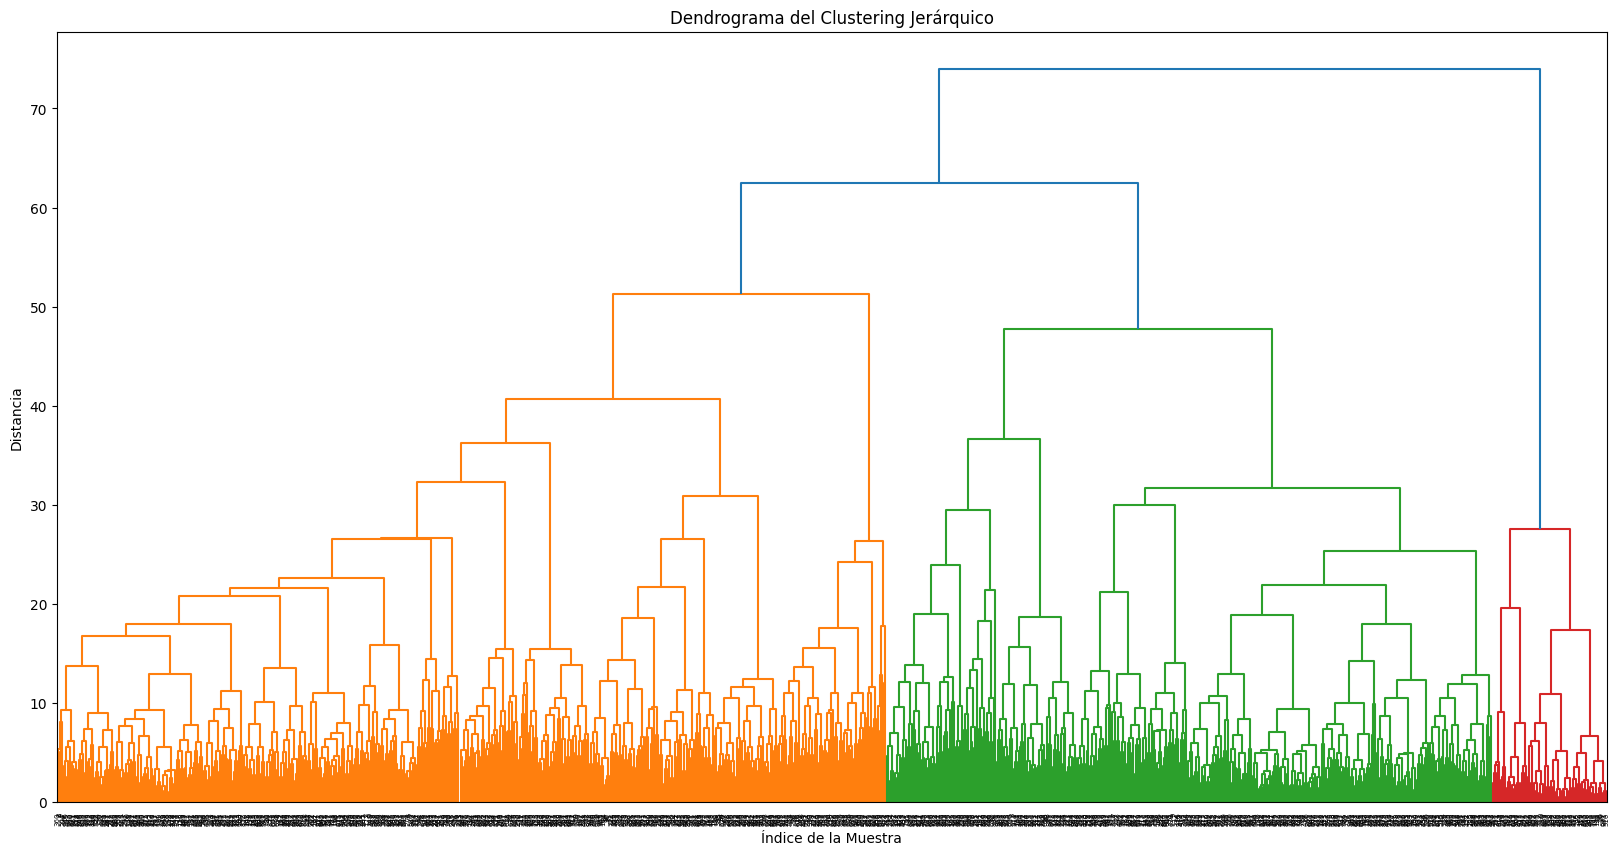

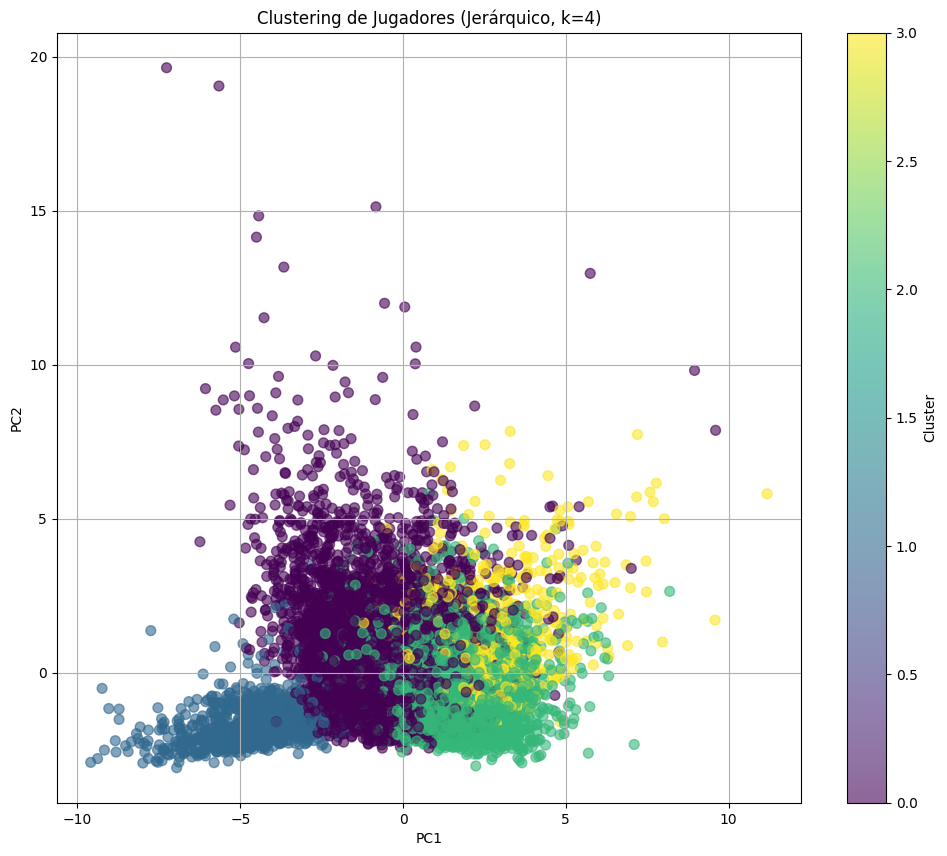

In [19]:
# Aplicar clustering jerárquico
# Primero crear un dendrograma para ayudar a seleccionar el número de clusters
plt.figure(figsize=(20, 10))
# Utilizar una muestra de datos si el dataset es muy grande
sample_size = min(1000, X_pca.shape[0])
sample_indices = np.random.choice(range(X_pca.shape[0]), sample_size, replace=False)
X_pca_sample = X_pca[sample_indices]

# Calcular el dendrograma
linked = linkage(X_pca_sample, 'ward')
dendrogram(linked, 
           orientation='top',
           labels=None,
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrograma del Clustering Jerárquico')
plt.xlabel('Índice de la Muestra')
plt.ylabel('Distancia')
plt.show()

# Aplicar Clustering Jerárquico con el número óptimo de clusters
hc = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hc_labels = hc.fit_predict(X_pca)

# Añadir etiquetas al dataframe
data_prep['hc_cluster'] = hc_labels

# Visualizar resultados
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=hc_labels, cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter, label='Cluster')
plt.title(f'Clustering de Jugadores (Jerárquico, k={optimal_k})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

Comparación de algoritmos de clustering:
    Algoritmo   Silueta  Davies-Bouldin  Clusters  Outliers
0     K-means  0.109434        2.501645         4         0
1      DBSCAN       NaN             NaN         0     10376
2  Jerárquico  0.070292        2.933250         4         0


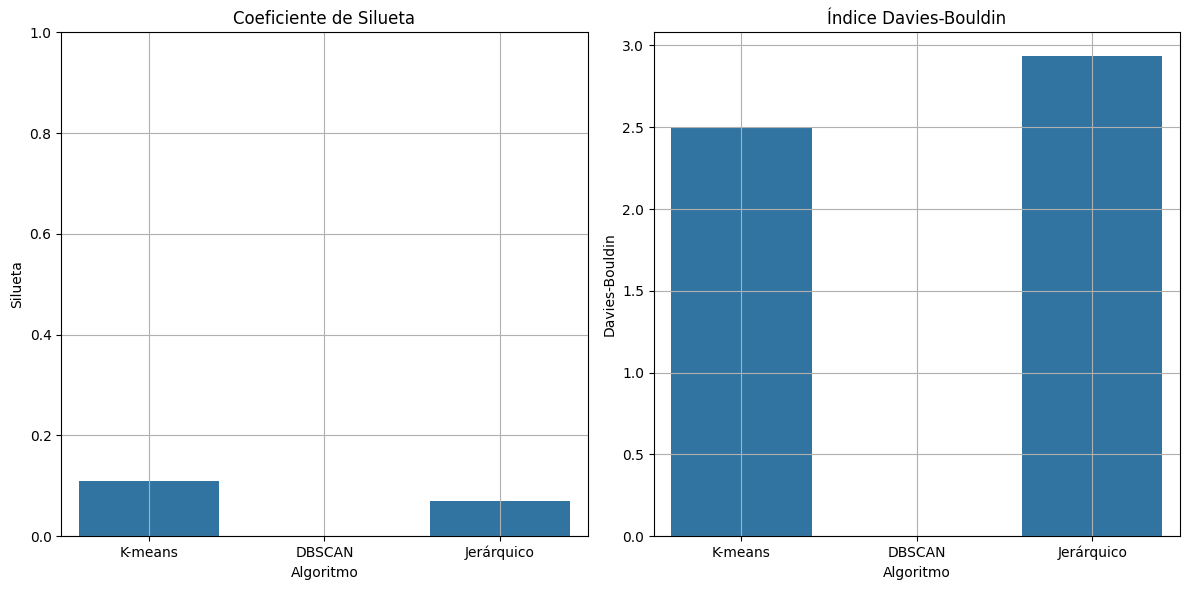

In [20]:
# Comparar métricas de calidad para diferentes algoritmos
def compare_clustering_algorithms(X, kmeans_labels, dbscan_labels, hc_labels):
    # Filtrar outliers de DBSCAN (etiqueta -1) para la comparación
    dbscan_mask = dbscan_labels != -1
    
    # Calcular métricas
    metrics = {
        'Algoritmo': ['K-means', 'DBSCAN', 'Jerárquico'],
        'Silueta': [
            silhouette_score(X, kmeans_labels),
            silhouette_score(X[dbscan_mask], dbscan_labels[dbscan_mask]) if np.sum(dbscan_mask) > 0 else np.nan,
            silhouette_score(X, hc_labels)
        ],
        'Davies-Bouldin': [
            davies_bouldin_score(X, kmeans_labels),
            davies_bouldin_score(X[dbscan_mask], dbscan_labels[dbscan_mask]) if np.sum(dbscan_mask) > 0 else np.nan,
            davies_bouldin_score(X, hc_labels)
        ],
        'Clusters': [
            len(np.unique(kmeans_labels)),
            len(np.unique(dbscan_labels[dbscan_labels != -1])),
            len(np.unique(hc_labels))
        ],
        'Outliers': [
            0,  # K-Means no identifica outliers
            np.sum(dbscan_labels == -1),
            0   # Clustering jerárquico no identifica outliers
        ]
    }
    
    return pd.DataFrame(metrics)

# Calcular y mostrar comparativa
comparison_df = compare_clustering_algorithms(X_pca, cluster_labels, dbscan_labels, hc_labels)
print("Comparación de algoritmos de clustering:")
print(comparison_df)

# Visualizar comparativa
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Algoritmo', y='Silueta', data=comparison_df)
plt.title('Coeficiente de Silueta')
plt.ylim(0, 1)
plt.grid(True)

plt.subplot(1, 2, 2)
sns.barplot(x='Algoritmo', y='Davies-Bouldin', data=comparison_df)
plt.title('Índice Davies-Bouldin')
plt.grid(True)

plt.tight_layout()
plt.show()

Resumen de características por cluster:
                 xmedia     ymedia  pases_adelante_por90  pases_atras_por90  \
best_cluster                                                                  
0             47.929567  60.625861              4.719858           5.152300   
1             50.467151  10.810291             14.372522           0.036339   
2             49.480001  38.280528             11.189066           3.818043   
3             50.822763  53.910590              4.095456           3.643589   

              regates_zona_finalizacion_por90  disparos_a_puerta_por90  \
best_cluster                                                             
0                                    1.691421                 0.505480   
1                                    0.003279                 0.001093   
2                                    0.147519                 0.087767   
3                                    0.408659                 0.308556   

              recuperaciones_zona_baja_p

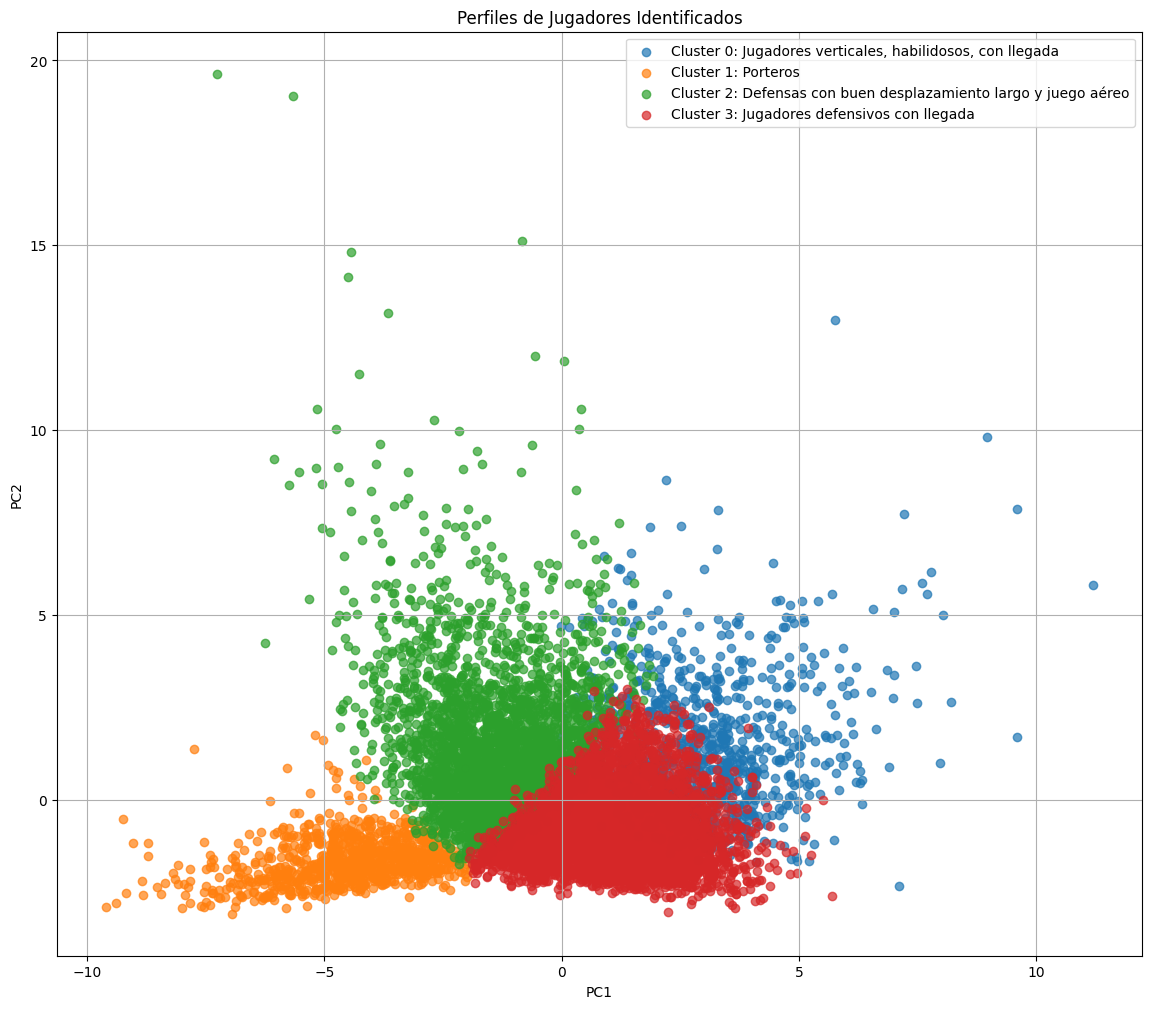

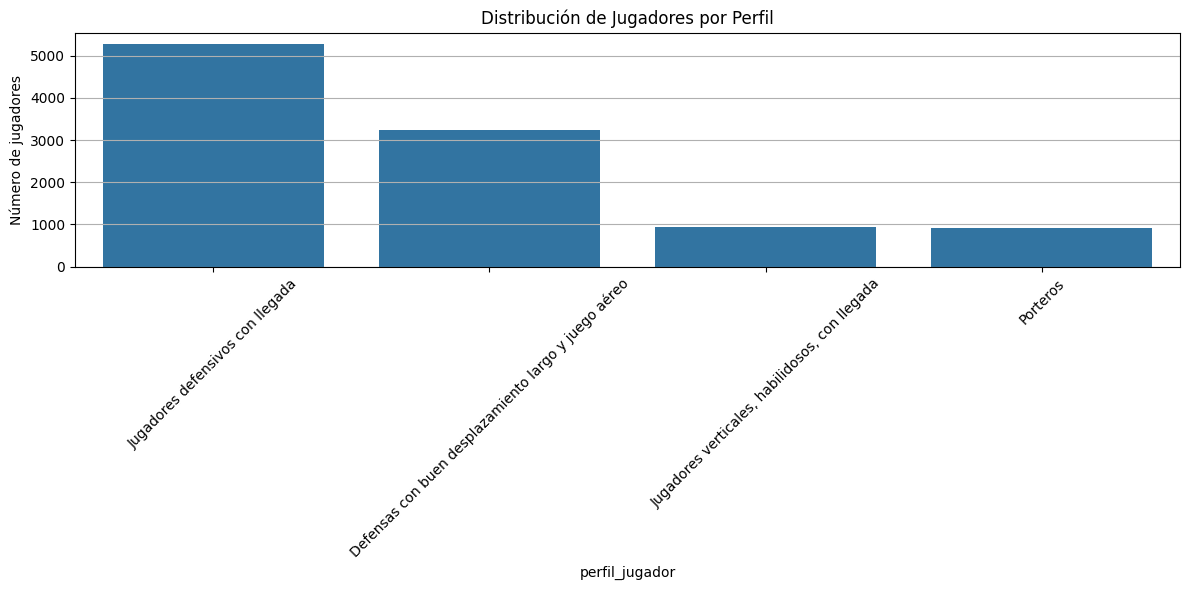

In [31]:
# Seleccionamos el mejor algoritmo basado en las métricas (asumimos K-means)
best_labels = cluster_labels
data_prep['best_cluster'] = best_labels

# Asignar nombres descriptivos a los clusters
# Esto requiere analizar las características principales de cada cluster
cluster_names = {}

# Analizar características clave por cluster
cluster_summary = data_prep.groupby('best_cluster').agg({
    'xmedia': 'mean',
    'ymedia': 'mean',
    'pases_adelante_por90': 'mean',
    'pases_atras_por90': 'mean',
    'regates_zona_finalizacion_por90': 'mean',
    'disparos_a_puerta_por90': 'mean',
    'recuperaciones_zona_baja_por90': 'mean',
    'intercepciones_zona_media_por90': 'mean',
    'duelos_aereos_ganados_zona_media_por90': 'mean',
    'xg_por90': 'mean',
    'demarcacion': lambda x: x.value_counts().index[0]  # Posición más común
})

print("Resumen de características por cluster:")
print(cluster_summary)

# Basado en el análisis, asignar nombres descriptivos
cluster_names = {
    0: "Jugadores verticales, habilidosos, con llegada",
    1: "Porteros",
    2: "Defensas con buen desplazamiento largo y juego aéreo",
    3: "Jugadores defensivos con llegada"
}

# Si el número óptimo de clusters difiere, ajustar los nombres manualmente
for i in range(optimal_k):
    if i not in cluster_names:
        cluster_names[i] = f"Perfil {i}"

# Añadir nombres descriptivos al dataframe
data_prep['perfil_jugador'] = data_prep['best_cluster'].map(cluster_names)

# Visualizar clusters con nombres descriptivos
plt.figure(figsize=(14, 12))
for cluster in range(optimal_k):
    cluster_data = data_prep[data_prep['best_cluster'] == cluster]
    plt.scatter(
        cluster_data['PC1'], 
        cluster_data['PC2'],
        alpha=0.7,
        label=f"Cluster {cluster}: {cluster_names[cluster]}"
    )

plt.title('Perfiles de Jugadores Identificados')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.legend()
plt.show()

# Distribución de perfiles
plt.figure(figsize=(12, 6))
profile_counts = data_prep['perfil_jugador'].value_counts()
sns.barplot(x=profile_counts.index, y=profile_counts.values)
plt.title('Distribución de Jugadores por Perfil')
plt.ylabel('Número de jugadores')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

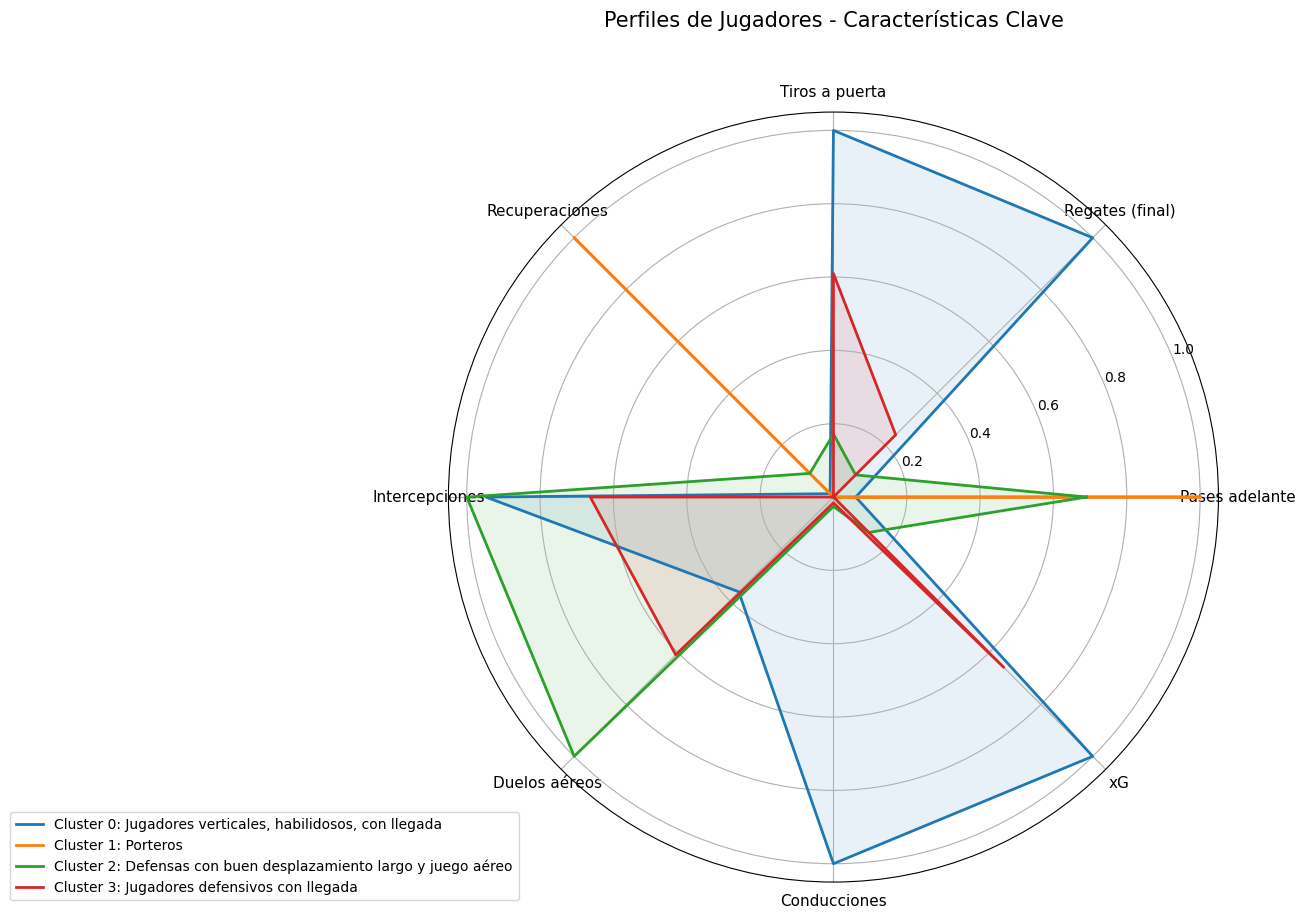

In [32]:
# Función para crear radar chart
def create_radar_chart(data, categories, title):
    # Número de variables
    N = len(categories)
    
    # Ángulo para cada categoría
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Cerrar el polígono
    
    # Crear figura
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Añadir cada perfil
    for i, (idx, row) in enumerate(data.iterrows()):
        values = row.values.flatten().tolist()
        values += values[:1]  # Cerrar el polígono
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Cluster {idx}: {cluster_names[idx]}")
        ax.fill(angles, values, alpha=0.1)
    
    # Categorías en el chart
    plt.xticks(angles[:-1], categories, size=11)
    
    # Título y leyenda
    plt.title(title, size=15, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    return fig, ax

# Seleccionar características clave para el radar chart
radar_features = [
    'pases_adelante_por90',
    'regates_zona_finalizacion_por90',
    'disparos_a_puerta_por90',
    'recuperaciones_zona_baja_por90',
    'intercepciones_zona_media_por90',
    'duelos_aereos_ganados_zona_media_por90',
    'conducciones_finalizacion_por90',
    'xg_por90'
]

# Preparar datos normalizados para el radar chart
radar_data = data_prep.groupby('best_cluster')[radar_features].mean()

# Normalizar para que estén en escala 0-1
radar_data_norm = (radar_data - radar_data.min()) / (radar_data.max() - radar_data.min())

# Nombres más cortos para las categorías en el gráfico
radar_categories = [
    'Pases adelante',
    'Regates (final)',
    'Tiros a puerta',
    'Recuperaciones',
    'Intercepciones',
    'Duelos aéreos',
    'Conducciones',
    'xG'
]

# Crear radar chart
fig, ax = create_radar_chart(
    radar_data_norm, 
    radar_categories, 
    'Perfiles de Jugadores - Características Clave'
)
plt.show()

In [33]:
# Identificar jugadores representativos de cada cluster
# Calculamos la distancia euclidiana de cada punto al centroide de su cluster

# Función para calcular distancia al centroide
def distance_to_centroid(row, centroids, cluster_col='best_cluster'):
    cluster = int(row[cluster_col])
    centroid = centroids[cluster]
    # Usamos PC1 y PC2 para simplicidad
    point = np.array([row['PC1'], row['PC2']])
    return np.linalg.norm(point - centroid)

# Calcular centroides en el espacio PCA
centroids = np.array([
    data_prep[data_prep['best_cluster'] == i][['PC1', 'PC2']].mean().values
    for i in range(optimal_k)
])

# Calcular distancia de cada punto a su centroide
data_prep['distance_to_centroid'] = data_prep.apply(
    lambda row: distance_to_centroid(row, centroids), axis=1
)

# Identificar los 3 jugadores más representativos de cada cluster
representative_players = []
for cluster in range(optimal_k):
    cluster_players = data_prep[data_prep['best_cluster'] == cluster].nsmallest(3, 'distance_to_centroid')
    representative_players.append(cluster_players)

# Combinar en un solo DataFrame
representative_df = pd.concat(representative_players)

# Mostrar jugadores representativos
print("Jugadores más representativos de cada perfil:")
for cluster in range(optimal_k):
    players = representative_df[representative_df['best_cluster'] == cluster]
    print(f"\nCluster {cluster}: {cluster_names[cluster]}")
    for _, player in players.iterrows():
        print(f"  - {player['jugador']} ({player['demarcacion']}, {player['equipo']})")

Jugadores más representativos de cada perfil:

Cluster 0: Jugadores verticales, habilidosos, con llegada
  - Zubiria  (Delantero Centro, SD Eibar Juv. A)
  - Isaac Rodriguez Marin (Carrilero Derecho, Deportivo Alavés C)
  - Oier Diaz (Mediocentro, Deportivo Alavés C)

Cluster 1: Porteros
  - Victor Diez Encinas (Portero, Deportivo Alavés Juv. A)
  - Oleksander Kosariev (Portero, Deportivo Alavés C)
  - Asier Gago (Portero, Deportivo Alavés C)

Cluster 2: Defensas con buen desplazamiento largo y juego aéreo
  - Alvaro Garcia Blanes (Defensa Central, Deportivo Alavés B)
  - Antonio Sola Villalba (Lateral Izquierdo, SD Ejea)
  - Alejandro Ibarrondo Gorostidi (Lateral Derecho, Arenas Club)

Cluster 3: Jugadores defensivos con llegada
  - Javier Martinez Zapata (Delantero Centro, CA Osasuna Juv. A)
  - Alexander Perez Garitano (Delantero Centro, SD Leioa)
  - Iker Uria Porres (Carrilero Izquierdo, Deportivo Alavés C)


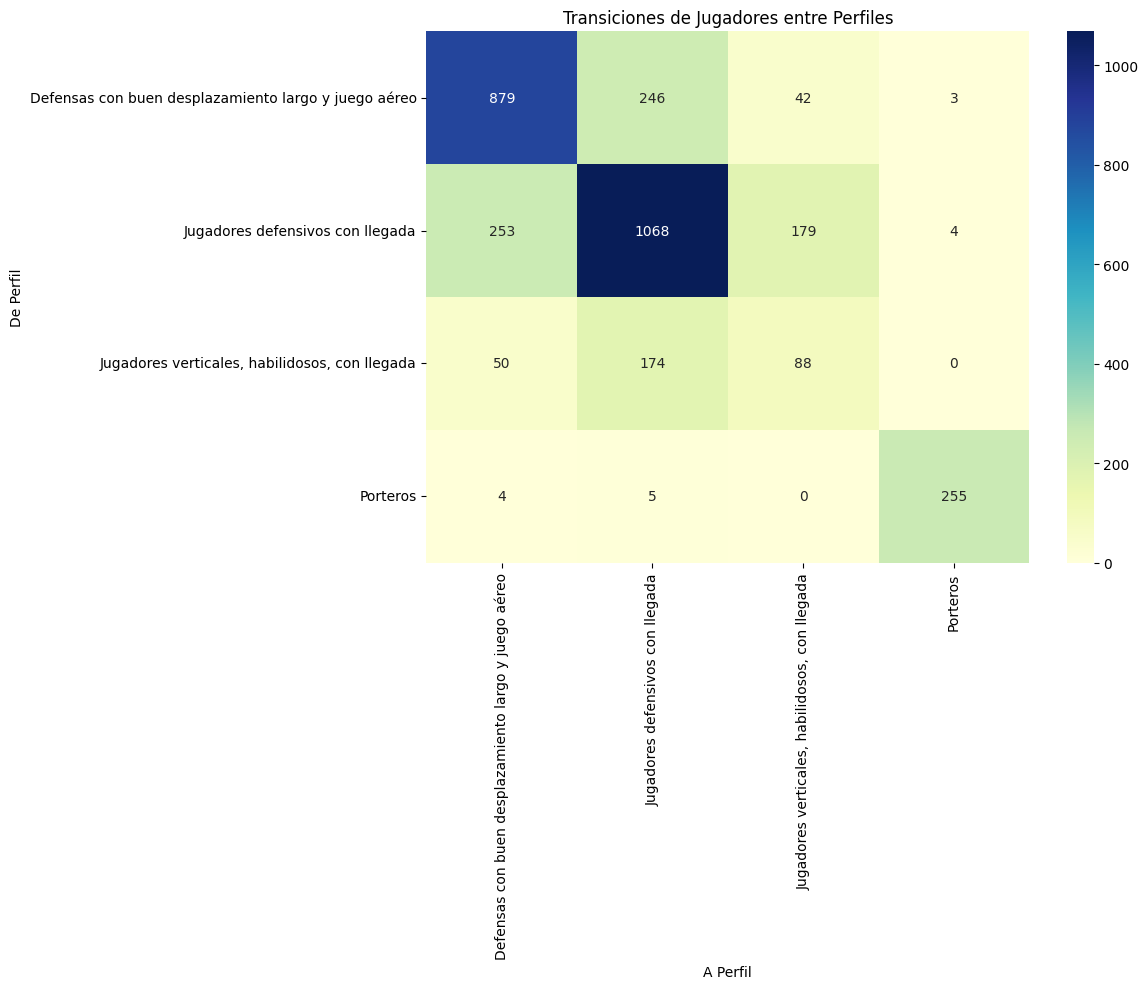

Ejemplos de jugadores que cambiaron de perfil:
Ander Santamaria: Defensas con buen desplazamiento largo y juego aéreo (21/22) → Jugadores defensivos con llegada (21/22)
Ander Santamaria: Jugadores defensivos con llegada (23/24) → Defensas con buen desplazamiento largo y juego aéreo (23/24)
Álex Balboa: Defensas con buen desplazamiento largo y juego aéreo (21/22) → Jugadores defensivos con llegada (21/22)
Álex Balboa: Jugadores defensivos con llegada (21/22) → Defensas con buen desplazamiento largo y juego aéreo (21/22)
Álex Balboa: Defensas con buen desplazamiento largo y juego aéreo (21/22) → Jugadores defensivos con llegada (22/23)
Sugoi Soto: Defensas con buen desplazamiento largo y juego aéreo (21/22) → Jugadores defensivos con llegada (23/24)
Sugoi Soto: Jugadores defensivos con llegada (23/24) → Defensas con buen desplazamiento largo y juego aéreo (24/25)
Eneko Martinez: Jugadores defensivos con llegada (22/23) → Defensas con buen desplazamiento largo y juego aéreo (22/23)
Eneko 

In [34]:
# Este análisis sería más valioso con datos longitudinales
# pero podemos simular con datos por temporada

# Verificar si tenemos múltiples temporadas
if len(data_prep['temporada'].unique()) > 1:
    # Filtrar jugadores que aparecen en más de una temporada
    player_seasons = data_prep.groupby('player_id')['temporada'].nunique()
    multi_season_players = player_seasons[player_seasons > 1].index
    
    # Analizar cambios de perfil por jugador entre temporadas
    transitions = []
    for player_id in multi_season_players:
        player_data = data_prep[data_prep['player_id'] == player_id].sort_values('temporada')
        if len(player_data) > 1:
            for i in range(len(player_data) - 1):
                from_cluster = player_data.iloc[i]['best_cluster']
                to_cluster = player_data.iloc[i+1]['best_cluster']
                from_season = player_data.iloc[i]['temporada']
                to_season = player_data.iloc[i+1]['temporada']
                
                transitions.append({
                    'player_id': player_id,
                    'jugador': player_data.iloc[0]['jugador'],
                    'from_cluster': from_cluster,
                    'to_cluster': to_cluster,
                    'from_profile': cluster_names[from_cluster],
                    'to_profile': cluster_names[to_cluster],
                    'from_season': from_season,
                    'to_season': to_season
                })
    
    transitions_df = pd.DataFrame(transitions)
    
    # Contar transiciones entre perfiles
    transition_counts = pd.crosstab(
        transitions_df['from_profile'], 
        transitions_df['to_profile'],
        rownames=['De Perfil'],
        colnames=['A Perfil']
    )
    
    # Visualizar matriz de transiciones
    plt.figure(figsize=(12, 10))
    sns.heatmap(transition_counts, annot=True, cmap='YlGnBu', fmt='d')
    plt.title('Transiciones de Jugadores entre Perfiles')
    plt.tight_layout()
    plt.show()
    
    # Mostrar ejemplos de jugadores que cambiaron de perfil
    if len(transitions_df) > 0:
        print("Ejemplos de jugadores que cambiaron de perfil:")
        transition_examples = transitions_df[transitions_df['from_cluster'] != transitions_df['to_cluster']].head(10)
        for _, row in transition_examples.iterrows():
            print(f"{row['jugador']}: {row['from_profile']} ({row['from_season']}) → {row['to_profile']} ({row['to_season']})")
else:
    print("No hay suficientes temporadas para analizar transiciones entre perfiles.")

In [35]:
import joblib

# Exportar modelo, PCA y scaler
joblib.dump(kmeans, 'modelo_kmeans_perfiles.pkl')
joblib.dump(pca, 'pca_perfiles.pkl')
joblib.dump(scaler, 'scaler_perfiles.pkl')

# Exportar mapeo de clusters a perfiles
import json
with open('cluster_names.json', 'w') as f:
    json.dump(cluster_names, f)

print("Modelos y metadatos guardados exitosamente.")

Modelos y metadatos guardados exitosamente.


In [36]:
def clasificar_jugador(datos_jugador, scaler, pca, kmeans, cluster_names):
    """
    Clasifica a un nuevo jugador en uno de los perfiles identificados.
    
    Parámetros:
    datos_jugador -- DataFrame con las características del jugador
    scaler -- Scaler entrenado
    pca -- Modelo PCA entrenado
    kmeans -- Modelo K-means entrenado
    cluster_names -- Diccionario con nombres descriptivos de clusters
    
    Retorno:
    Diccionario con cluster asignado y nombre del perfil
    """
    # Verificar si el DataFrame tiene todas las características necesarias
    for feature in vars_clustering_norm:
        if feature not in datos_jugador.columns:
            print(f"Advertencia: Falta la característica {feature}. Se asumirá valor 0.")
            datos_jugador[feature] = 0
    
    # Seleccionar las características correctas
    X = datos_jugador[vars_clustering_norm].values
    
    # Escalar datos
    X_scaled = scaler.transform(X)
    
    # Proyectar a espacio PCA
    X_pca = pca.transform(X_scaled)
    
    # Predecir cluster
    cluster = kmeans.predict(X_pca)[0]
    
    # Obtener nombre del perfil
    perfil = cluster_names.get(str(cluster), f"Perfil {cluster}")
    
    return {
        'cluster': cluster,
        'perfil': perfil,
        'pca_coords': X_pca[0]
    }

# Ejemplo de uso con un jugador aleatorio
jugador_ejemplo = data_prep.sample(1)
resultado = clasificar_jugador(
    jugador_ejemplo, 
    scaler, 
    pca, 
    kmeans, 
    {str(k): v for k, v in cluster_names.items()}  # Convertir claves a strings para JSON
)

print(f"Jugador: {jugador_ejemplo['jugador'].values[0]}")
print(f"Posición: {jugador_ejemplo['demarcacion'].values[0]}")
print(f"Equipo: {jugador_ejemplo['equipo'].values[0]}")
print(f"Clasificado como: Cluster {resultado['cluster']} - {resultado['perfil']}")

Jugador: Juanma Segura
Posición: Mediocentro
Equipo: CD San Ignacio
Clasificado como: Cluster 2 - Defensas con buen desplazamiento largo y juego aéreo
